In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

import json

from imblearn.over_sampling import SMOTENC

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape

((256351, 68), (90067, 67))

In [5]:
train.head()

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [6]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [7]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()

시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [8]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [9]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [10]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [11]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [12]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [13]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [14]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [15]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '배아 생성 주요 이유', '총 시술 횟수',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수',
       'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수',
       '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부',
       '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일',
       '배아 해동 경과일', '임신 성공 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', 'PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = [ '임신 시도 또는 마지막 임신 경과 연수',"총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '총 생성 배아 수','미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

58

In [18]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 66), (90067, 66))

In [20]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [21]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [22]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True)
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
         "random_state":  trial.suggest_int('random_state', 42, 42),
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5, log=False),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1, log=False),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [23]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # SMOTENC 적용
    cat_indices = [X.columns.get_loc(col) for col in categorical_columns]
    
    smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
    X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

    # 모델 학습에 사용할 데이터를 SMOTENC 결과로 교체
    X_train = X_train_res  
    y_train = y_train_res  

    print("After SMOTENC:")
    print(np.bincount(y_train))
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    
    best_val_auc = 0

    # ---------------- CatBoost Optuna 튜닝 ----------------
    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    cat_model_path = f"./weight/cat_fold_cpu{idx}.cbm"
    model_cat = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=42, task_type="CPU")
    model_cat.load_model(cat_model_path)

    # ---------------- LightGBM Optuna 튜닝 ----------------
    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 20)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred_cat = model_cat.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred_cat)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cat+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred_cat = model_cat.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cat+test_pred_lgbm)/2)

Seed 42 Start!


[I 2025-02-20 01:59:52,852] A new study created in memory with name: no-name-b8be1ce0-8452-4615-b4a7-1a83737e9915


After SMOTENC:
[171110 171110]
X_train shape: (342220, 66)
y_train shape: (342220,)
0:	test: 0.7248003	best: 0.7248003 (0)	total: 242ms	remaining: 7m 3s
300:	test: 0.7208816	best: 0.7278207 (35)	total: 58.9s	remaining: 4m 43s


[I 2025-02-20 02:00:59,126] Trial 0 finished with value: 0.7278207233448091 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7278207233448091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278207233
bestIteration = 35

Shrink model to first 36 iterations.
저장 완료
0:	test: 0.7186940	best: 0.7186940 (0)	total: 111ms	remaining: 2m 25s
300:	test: 0.7261905	best: 0.7262135 (298)	total: 23.4s	remaining: 1m 18s
600:	test: 0.7273001	best: 0.7276040 (448)	total: 47.4s	remaining: 56.1s


[I 2025-02-20 02:01:59,592] Trial 1 finished with value: 0.7276040236271504 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7278207233448091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7276040236
bestIteration = 448

Shrink model to first 449 iterations.
0:	test: 0.7247264	best: 0.7247264 (0)	total: 149ms	remaining: 5m 28s
300:	test: 0.7271243	best: 0.7271497 (298)	total: 36.4s	remaining: 3m 49s
600:	test: 0.7280106	best: 0.7282688 (440)	total: 1m 15s	remaining: 3m 20s


[I 2025-02-20 02:03:33,416] Trial 2 finished with value: 0.7282687944330214 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7282687944330214.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7282687944
bestIteration = 440

Shrink model to first 441 iterations.
저장 완료
0:	test: 0.7186719	best: 0.7186719 (0)	total: 83.8ms	remaining: 3m 43s
300:	test: 0.7274571	best: 0.7281184 (216)	total: 23.3s	remaining: 3m 3s


[I 2025-02-20 02:04:14,282] Trial 3 finished with value: 0.7281184169395323 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7282687944330214.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7281184169
bestIteration = 216

Shrink model to first 217 iterations.
0:	test: 0.7215187	best: 0.7215187 (0)	total: 126ms	remaining: 3m 21s
300:	test: 0.7240005	best: 0.7280429 (69)	total: 34s	remaining: 2m 27s


[I 2025-02-20 02:04:56,304] Trial 4 finished with value: 0.7280429065679205 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7282687944330214.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280429066
bestIteration = 69

Shrink model to first 70 iterations.
0:	test: 0.7160182	best: 0.7160182 (0)	total: 69.2ms	remaining: 2m 33s
300:	test: 0.7271090	best: 0.7276872 (205)	total: 18.9s	remaining: 2m


[I 2025-02-20 02:05:28,631] Trial 5 finished with value: 0.7276872252008346 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7282687944330214.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7276872252
bestIteration = 205

Shrink model to first 206 iterations.
0:	test: 0.7248001	best: 0.7248001 (0)	total: 158ms	remaining: 5m 2s
300:	test: 0.7258027	best: 0.7284528 (94)	total: 43.8s	remaining: 3m 54s


[I 2025-02-20 02:06:26,686] Trial 6 finished with value: 0.7284528432706378 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 6 with value: 0.7284528432706378.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7284528433
bestIteration = 94

Shrink model to first 95 iterations.
저장 완료
0:	test: 0.7160182	best: 0.7160182 (0)	total: 68.8ms	remaining: 2m 30s
300:	test: 0.7245048	best: 0.7274932 (90)	total: 20.2s	remaining: 2m 6s


[I 2025-02-20 02:06:53,190] Trial 7 finished with value: 0.7274931821682693 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 6 with value: 0.7284528432706378.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7274931822
bestIteration = 90

Shrink model to first 91 iterations.
0:	test: 0.7248205	best: 0.7248205 (0)	total: 194ms	remaining: 3m 39s
300:	test: 0.7212760	best: 0.7277901 (27)	total: 1m 2s	remaining: 2m 50s


[I 2025-02-20 02:08:01,135] Trial 8 finished with value: 0.7277901491290331 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 6 with value: 0.7284528432706378.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7277901491
bestIteration = 27

Shrink model to first 28 iterations.
0:	test: 0.7160182	best: 0.7160182 (0)	total: 69.8ms	remaining: 1m 52s
300:	test: 0.7249293	best: 0.7284788 (121)	total: 19.8s	remaining: 1m 26s


[I 2025-02-20 02:08:29,145] Trial 9 finished with value: 0.7284787717938868 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 9 with value: 0.7284787717938868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7284787718
bestIteration = 121

Shrink model to first 122 iterations.
저장 완료
0:	test: 0.7190317	best: 0.7190317 (0)	total: 92.5ms	remaining: 4m 27s
300:	test: 0.7228746	best: 0.7291078 (50)	total: 29.3s	remaining: 4m 12s


[I 2025-02-20 02:09:03,478] Trial 10 finished with value: 0.7291077985620414 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.08607984985807723, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7291077986
bestIteration = 50

Shrink model to first 51 iterations.
저장 완료
0:	test: 0.7190317	best: 0.7190317 (0)	total: 107ms	remaining: 5m 7s
300:	test: 0.7228449	best: 0.7280673 (32)	total: 29.6s	remaining: 4m 13s


[I 2025-02-20 02:09:36,615] Trial 11 finished with value: 0.7280672547615747 and parameters: {'iterations': 2872, 'depth': 6, 'learning_rate': 0.08799775706891638, 'l2_leaf_reg': 0.00014021053893291646}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280672548
bestIteration = 32

Shrink model to first 33 iterations.
0:	test: 0.7190317	best: 0.7190317 (0)	total: 106ms	remaining: 4m 31s
300:	test: 0.7234613	best: 0.7277418 (53)	total: 29.6s	remaining: 3m 43s


[I 2025-02-20 02:10:11,714] Trial 12 finished with value: 0.7277418101026881 and parameters: {'iterations': 2568, 'depth': 6, 'learning_rate': 0.0761634637694371, 'l2_leaf_reg': 1.1922848379901636}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7277418101
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.7190317	best: 0.7190317 (0)	total: 101ms	remaining: 2m 33s
300:	test: 0.7239898	best: 0.7284667 (67)	total: 29.2s	remaining: 1m 58s


[I 2025-02-20 02:10:48,068] Trial 13 finished with value: 0.728466665198575 and parameters: {'iterations': 1526, 'depth': 6, 'learning_rate': 0.058551450909013904, 'l2_leaf_reg': 0.00012822537872531778}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7284666652
bestIteration = 67

Shrink model to first 68 iterations.
0:	test: 0.7186719	best: 0.7186719 (0)	total: 87.7ms	remaining: 4m 21s
300:	test: 0.7234057	best: 0.7280929 (53)	total: 25.8s	remaining: 3m 49s


[I 2025-02-20 02:11:18,883] Trial 14 finished with value: 0.7280928934253754 and parameters: {'iterations': 2982, 'depth': 5, 'learning_rate': 0.07905935604767556, 'l2_leaf_reg': 0.026761335821027646}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280928934
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.7215187	best: 0.7215187 (0)	total: 117ms	remaining: 4m 52s
300:	test: 0.7218191	best: 0.7281650 (26)	total: 36.1s	remaining: 4m 23s


[I 2025-02-20 02:11:58,304] Trial 15 finished with value: 0.7281650287212198 and parameters: {'iterations': 2501, 'depth': 7, 'learning_rate': 0.09955248709610441, 'l2_leaf_reg': 0.002664565684193682}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7281650287
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.7160182	best: 0.7160182 (0)	total: 73.7ms	remaining: 1m 38s
300:	test: 0.7255135	best: 0.7272984 (149)	total: 20.5s	remaining: 1m 11s


[I 2025-02-20 02:12:28,944] Trial 16 finished with value: 0.7272983569122612 and parameters: {'iterations': 1344, 'depth': 4, 'learning_rate': 0.05072240683177215, 'l2_leaf_reg': 0.06091097820609017}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7272983569
bestIteration = 149

Shrink model to first 150 iterations.
0:	test: 0.7247004	best: 0.7247004 (0)	total: 127ms	remaining: 4m 6s
300:	test: 0.7215414	best: 0.7281230 (34)	total: 38.9s	remaining: 3m 32s


[I 2025-02-20 02:13:12,464] Trial 17 finished with value: 0.728123007042576 and parameters: {'iterations': 1941, 'depth': 8, 'learning_rate': 0.06886489490982325, 'l2_leaf_reg': 0.0004420611755869484}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.728123007
bestIteration = 34

Shrink model to first 35 iterations.
0:	test: 0.7186719	best: 0.7186719 (0)	total: 82.5ms	remaining: 1m 26s
300:	test: 0.7237131	best: 0.7286115 (66)	total: 25s	remaining: 1m 2s


[I 2025-02-20 02:13:43,118] Trial 18 finished with value: 0.7286114599196769 and parameters: {'iterations': 1051, 'depth': 5, 'learning_rate': 0.0867919000139665, 'l2_leaf_reg': 1.2972618567849967}. Best is trial 10 with value: 0.7291077985620414.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7286114599
bestIteration = 66

Shrink model to first 67 iterations.
0:	test: 0.7190317	best: 0.7190317 (0)	total: 95.8ms	remaining: 1m 38s
300:	test: 0.7237545	best: 0.7271980 (54)	total: 30.3s	remaining: 1m 13s


[I 2025-02-20 02:14:19,481] Trial 19 finished with value: 0.7271979821589365 and parameters: {'iterations': 1026, 'depth': 6, 'learning_rate': 0.08732644306235746, 'l2_leaf_reg': 1.3732267241391563}. Best is trial 10 with value: 0.7291077985620414.
[I 2025-02-20 02:14:19,483] A new study created in memory with name: no-name-1e9bed05-7899-47b0-aad1-add7b065526d


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7271979822
bestIteration = 54

Shrink model to first 55 iterations.


[I 2025-02-20 02:14:43,582] Trial 0 finished with value: 0.7232546508405102 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7232546508405102.
[I 2025-02-20 02:14:45,994] Trial 1 finished with value: 0.7275997432369418 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7275997432369418.
[I 2025-02-20 02:15:08,467] Trial 2 finished with value: 0.7249992394167492 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7291077985620414
LGBM val score : 0.7281118176737376
Ensemble val score : 0.7301572088850831


[I 2025-02-20 02:19:55,110] A new study created in memory with name: no-name-9e1c1800-9a60-4cf5-b927-25571945d788


After SMOTENC:
[171110 171110]
X_train shape: (342220, 66)
y_train shape: (342220,)
0:	test: 0.7131915	best: 0.7131915 (0)	total: 189ms	remaining: 5m 30s
300:	test: 0.7087181	best: 0.7148724 (23)	total: 57.9s	remaining: 4m 38s


[I 2025-02-20 02:20:57,775] Trial 0 finished with value: 0.71487238309327 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.71487238309327.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7148723831
bestIteration = 23

Shrink model to first 24 iterations.
저장 완료
0:	test: 0.7062165	best: 0.7062165 (0)	total: 81.9ms	remaining: 1m 47s
300:	test: 0.7132870	best: 0.7134627 (283)	total: 24.4s	remaining: 1m 21s
600:	test: 0.7138687	best: 0.7145794 (395)	total: 49.8s	remaining: 58.9s


[I 2025-02-20 02:21:55,875] Trial 1 finished with value: 0.7145794021331444 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.71487238309327.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7145794021
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7124035	best: 0.7124035 (0)	total: 137ms	remaining: 5m 2s


[I 2025-02-20 02:22:34,383] Trial 2 finished with value: 0.715567582929755 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.715567582929755.


300:	test: 0.7142556	best: 0.7155676 (1)	total: 38.2s	remaining: 4m 1s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7155675829
bestIteration = 1

Shrink model to first 2 iterations.
저장 완료
0:	test: 0.7061447	best: 0.7061447 (0)	total: 83ms	remaining: 3m 41s
300:	test: 0.7143949	best: 0.7152280 (157)	total: 24.5s	remaining: 3m 12s


[I 2025-02-20 02:23:12,365] Trial 3 finished with value: 0.7152280387468919 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.715567582929755.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7152280387
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.7131955	best: 0.7131955 (0)	total: 111ms	remaining: 2m 57s
300:	test: 0.7121597	best: 0.7165884 (48)	total: 33.7s	remaining: 2m 26s


[I 2025-02-20 02:23:51,569] Trial 4 finished with value: 0.7165883917381363 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7165883917
bestIteration = 48

Shrink model to first 49 iterations.
저장 완료
0:	test: 0.7013651	best: 0.7013651 (0)	total: 67.8ms	remaining: 2m 30s
300:	test: 0.7137141	best: 0.7142622 (162)	total: 19.1s	remaining: 2m 1s


[I 2025-02-20 02:24:21,401] Trial 5 finished with value: 0.7142621804982564 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7142621805
bestIteration = 162

Shrink model to first 163 iterations.
0:	test: 0.7096454	best: 0.7096454 (0)	total: 136ms	remaining: 4m 19s
300:	test: 0.7124035	best: 0.7159586 (84)	total: 44.1s	remaining: 3m 56s


[I 2025-02-20 02:25:18,106] Trial 6 finished with value: 0.7159586028049956 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7159586028
bestIteration = 84

Shrink model to first 85 iterations.
0:	test: 0.7013365	best: 0.7013365 (0)	total: 71.2ms	remaining: 2m 35s
300:	test: 0.7120766	best: 0.7147004 (55)	total: 20s	remaining: 2m 5s


[I 2025-02-20 02:25:41,944] Trial 7 finished with value: 0.7147003751728915 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7147003752
bestIteration = 55

Shrink model to first 56 iterations.
0:	test: 0.7132621	best: 0.7132621 (0)	total: 165ms	remaining: 3m 5s
300:	test: 0.7100055	best: 0.7164457 (20)	total: 1m	remaining: 2m 45s


[I 2025-02-20 02:26:46,285] Trial 8 finished with value: 0.7164456918419629 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7164456918
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.7013651	best: 0.7013651 (0)	total: 70.5ms	remaining: 1m 53s
300:	test: 0.7121171	best: 0.7146682 (116)	total: 19.6s	remaining: 1m 25s


[I 2025-02-20 02:27:13,680] Trial 9 finished with value: 0.7146682078292519 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7146682078
bestIteration = 116

Shrink model to first 117 iterations.
0:	test: 0.7131707	best: 0.7131707 (0)	total: 110ms	remaining: 5m 17s
300:	test: 0.7120557	best: 0.7163480 (45)	total: 32.9s	remaining: 4m 42s


[I 2025-02-20 02:27:51,893] Trial 10 finished with value: 0.7163479944566692 and parameters: {'iterations': 2891, 'depth': 7, 'learning_rate': 0.04584783385796229, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7163479945
bestIteration = 45

Shrink model to first 46 iterations.
0:	test: 0.7132010	best: 0.7132010 (0)	total: 112ms	remaining: 1m 58s
300:	test: 0.7114114	best: 0.7159576 (20)	total: 34.1s	remaining: 1m 25s


[I 2025-02-20 02:28:28,346] Trial 11 finished with value: 0.7159575861580855 and parameters: {'iterations': 1053, 'depth': 7, 'learning_rate': 0.0978834300631911, 'l2_leaf_reg': 2.7595819275754354}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7159575862
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.7123135	best: 0.7123135 (0)	total: 123ms	remaining: 2m 46s
300:	test: 0.7103702	best: 0.7160518 (20)	total: 38.9s	remaining: 2m 15s


[I 2025-02-20 02:29:10,172] Trial 12 finished with value: 0.7160517888196258 and parameters: {'iterations': 1347, 'depth': 8, 'learning_rate': 0.09927839108496424, 'l2_leaf_reg': 1.5238260374413366}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7160517888
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.7131742	best: 0.7131742 (0)	total: 177ms	remaining: 3m 11s
300:	test: 0.7097146	best: 0.7148935 (51)	total: 55.9s	remaining: 2m 25s


[I 2025-02-20 02:30:15,986] Trial 13 finished with value: 0.7148934546889925 and parameters: {'iterations': 1082, 'depth': 10, 'learning_rate': 0.048784330760991625, 'l2_leaf_reg': 0.008123019592628818}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7148934547
bestIteration = 51

Shrink model to first 52 iterations.
0:	test: 0.7056383	best: 0.7056383 (0)	total: 94.8ms	remaining: 2m 20s
300:	test: 0.7119358	best: 0.7160162 (38)	total: 28.9s	remaining: 1m 54s


[I 2025-02-20 02:30:48,740] Trial 14 finished with value: 0.7160161863213875 and parameters: {'iterations': 1488, 'depth': 6, 'learning_rate': 0.08313408480709152, 'l2_leaf_reg': 6.286925111326557}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7160161863
bestIteration = 38

Shrink model to first 39 iterations.
0:	test: 0.7123092	best: 0.7123092 (0)	total: 130ms	remaining: 2m 41s
300:	test: 0.7112971	best: 0.7150912 (18)	total: 37.7s	remaining: 1m 57s


[I 2025-02-20 02:31:28,889] Trial 15 finished with value: 0.7150912044268365 and parameters: {'iterations': 1243, 'depth': 8, 'learning_rate': 0.05914791267533459, 'l2_leaf_reg': 0.2622695738832672}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7150912044
bestIteration = 18

Shrink model to first 19 iterations.
0:	test: 0.7097973	best: 0.7097973 (0)	total: 135ms	remaining: 3m 48s
300:	test: 0.7120483	best: 0.7148728 (61)	total: 43s	remaining: 3m 19s


[I 2025-02-20 02:32:21,148] Trial 16 finished with value: 0.714872835818847 and parameters: {'iterations': 1695, 'depth': 9, 'learning_rate': 0.03694705348047124, 'l2_leaf_reg': 94.64533014403685}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7148728358
bestIteration = 61

Shrink model to first 62 iterations.
0:	test: 0.7055753	best: 0.7055753 (0)	total: 105ms	remaining: 2m 35s
300:	test: 0.7110852	best: 0.7157223 (31)	total: 29.1s	remaining: 1m 54s


[I 2025-02-20 02:32:53,565] Trial 17 finished with value: 0.7157223316803236 and parameters: {'iterations': 1481, 'depth': 6, 'learning_rate': 0.08645283934224565, 'l2_leaf_reg': 0.001800899469518755}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7157223317
bestIteration = 31

Shrink model to first 32 iterations.
0:	test: 0.7096441	best: 0.7096441 (0)	total: 139ms	remaining: 4m 34s
300:	test: 0.7118235	best: 0.7157139 (56)	total: 43.2s	remaining: 3m 59s


[I 2025-02-20 02:33:45,611] Trial 18 finished with value: 0.7157138808028836 and parameters: {'iterations': 1968, 'depth': 9, 'learning_rate': 0.04015627924463417, 'l2_leaf_reg': 0.737975784896599}. Best is trial 4 with value: 0.7165883917381363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7157138808
bestIteration = 56

Shrink model to first 57 iterations.
0:	test: 0.7055753	best: 0.7055753 (0)	total: 95.2ms	remaining: 1m 37s
300:	test: 0.7122014	best: 0.7157494 (60)	total: 28.7s	remaining: 1m 9s


[I 2025-02-20 02:34:20,307] Trial 19 finished with value: 0.7157494475596289 and parameters: {'iterations': 1026, 'depth': 6, 'learning_rate': 0.06052572572180504, 'l2_leaf_reg': 0.00025631809124133074}. Best is trial 4 with value: 0.7165883917381363.
[I 2025-02-20 02:34:20,309] A new study created in memory with name: no-name-8f26ceed-6a32-46ed-8f48-a7c4e8933d21


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7157494476
bestIteration = 60

Shrink model to first 61 iterations.


[I 2025-02-20 02:34:43,797] Trial 0 finished with value: 0.7109471729138322 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7109471729138322.
[I 2025-02-20 02:34:46,199] Trial 1 finished with value: 0.7173255957713716 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7173255957713716.
[I 2025-02-20 02:35:08,514] Trial 2 finished with value: 0.7123261591367257 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7165883917381363
LGBM val score : 0.7177287637829323
Ensemble val score : 0.7181694762471807


[I 2025-02-20 02:39:39,858] A new study created in memory with name: no-name-6c2847ee-a999-44ef-bbd3-c5964b637931


After SMOTENC:
[171110 171110]
X_train shape: (342220, 66)
y_train shape: (342220,)
0:	test: 0.7125889	best: 0.7125889 (0)	total: 179ms	remaining: 5m 12s
300:	test: 0.7184679	best: 0.7235083 (31)	total: 56.6s	remaining: 4m 32s


[I 2025-02-20 02:40:43,339] Trial 0 finished with value: 0.7235083180699949 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7235083180699949.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7235083181
bestIteration = 31

Shrink model to first 32 iterations.
저장 완료
0:	test: 0.7084939	best: 0.7084939 (0)	total: 101ms	remaining: 2m 13s
300:	test: 0.7215794	best: 0.7215794 (300)	total: 23.4s	remaining: 1m 18s
600:	test: 0.7235168	best: 0.7237435 (517)	total: 47.6s	remaining: 56.3s


[I 2025-02-20 02:41:48,877] Trial 1 finished with value: 0.7237435209211558 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7237435209211558.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237435209
bestIteration = 517

Shrink model to first 518 iterations.
저장 완료
0:	test: 0.7136116	best: 0.7136116 (0)	total: 125ms	remaining: 4m 35s
300:	test: 0.7212790	best: 0.7212790 (300)	total: 35.8s	remaining: 3m 46s
600:	test: 0.7232456	best: 0.7234345 (503)	total: 1m 13s	remaining: 3m 15s


[I 2025-02-20 02:43:27,898] Trial 2 finished with value: 0.7234345039445345 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 1 with value: 0.7237435209211558.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7234345039
bestIteration = 503

Shrink model to first 504 iterations.
0:	test: 0.7085102	best: 0.7085102 (0)	total: 79.9ms	remaining: 3m 32s
300:	test: 0.7234320	best: 0.7237985 (254)	total: 22.1s	remaining: 2m 53s


[I 2025-02-20 02:44:09,548] Trial 3 finished with value: 0.7237985350213336 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.723798535
bestIteration = 254

Shrink model to first 255 iterations.
저장 완료
0:	test: 0.7062897	best: 0.7062897 (0)	total: 108ms	remaining: 2m 53s
300:	test: 0.7209535	best: 0.7235313 (66)	total: 32.3s	remaining: 2m 20s


[I 2025-02-20 02:44:49,263] Trial 4 finished with value: 0.7235313197063358 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7235313197
bestIteration = 66

Shrink model to first 67 iterations.
0:	test: 0.7075873	best: 0.7075873 (0)	total: 71.6ms	remaining: 2m 39s
300:	test: 0.7231896	best: 0.7233727 (271)	total: 19s	remaining: 2m 1s


[I 2025-02-20 02:45:26,373] Trial 5 finished with value: 0.7233727227883613 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7233727228
bestIteration = 271

Shrink model to first 272 iterations.
0:	test: 0.7136927	best: 0.7136927 (0)	total: 161ms	remaining: 5m 7s
300:	test: 0.7225591	best: 0.7236068 (118)	total: 42.5s	remaining: 3m 47s


[I 2025-02-20 02:46:25,365] Trial 6 finished with value: 0.7236068057394103 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7236068057
bestIteration = 118

Shrink model to first 119 iterations.
0:	test: 0.7075873	best: 0.7075873 (0)	total: 68.9ms	remaining: 2m 30s
300:	test: 0.7213206	best: 0.7235130 (99)	total: 18.7s	remaining: 1m 56s


[I 2025-02-20 02:46:50,475] Trial 7 finished with value: 0.7235130280045081 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.723513028
bestIteration = 99

Shrink model to first 100 iterations.
0:	test: 0.7147439	best: 0.7147439 (0)	total: 159ms	remaining: 2m 59s
300:	test: 0.7204187	best: 0.7236019 (33)	total: 56.5s	remaining: 2m 35s


[I 2025-02-20 02:47:53,544] Trial 8 finished with value: 0.7236018813559395 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7236018814
bestIteration = 33

Shrink model to first 34 iterations.
0:	test: 0.7075873	best: 0.7075873 (0)	total: 67.4ms	remaining: 1m 48s
300:	test: 0.7212575	best: 0.7231228 (127)	total: 18.7s	remaining: 1m 21s


[I 2025-02-20 02:48:21,049] Trial 9 finished with value: 0.723122778557004 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 3 with value: 0.7237985350213336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7231227786
bestIteration = 127

Shrink model to first 128 iterations.
0:	test: 0.7081623	best: 0.7081623 (0)	total: 135ms	remaining: 6m 30s
300:	test: 0.7217955	best: 0.7245404 (113)	total: 28.3s	remaining: 4m 3s


[I 2025-02-20 02:49:00,534] Trial 10 finished with value: 0.7245403933912042 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7245403934
bestIteration = 113

Shrink model to first 114 iterations.
저장 완료
0:	test: 0.7081623	best: 0.7081623 (0)	total: 99.2ms	remaining: 4m 49s
300:	test: 0.7217464	best: 0.7237368 (134)	total: 27.8s	remaining: 4m 1s


[I 2025-02-20 02:49:41,346] Trial 11 finished with value: 0.7237367578364375 and parameters: {'iterations': 2920, 'depth': 6, 'learning_rate': 0.0395561372090833, 'l2_leaf_reg': 0.00011815814684318827}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237367578
bestIteration = 134

Shrink model to first 135 iterations.
0:	test: 0.7081623	best: 0.7081623 (0)	total: 94.8ms	remaining: 4m 38s
300:	test: 0.7229762	best: 0.7236617 (135)	total: 27.1s	remaining: 3m 57s


[I 2025-02-20 02:50:21,164] Trial 12 finished with value: 0.7236617285002171 and parameters: {'iterations': 2937, 'depth': 6, 'learning_rate': 0.023576108288886878, 'l2_leaf_reg': 0.00011410071589780009}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7236617285
bestIteration = 135

Shrink model to first 136 iterations.
0:	test: 0.7081623	best: 0.7081623 (0)	total: 93.8ms	remaining: 4m 3s
300:	test: 0.7209985	best: 0.7238136 (57)	total: 28.1s	remaining: 3m 34s


[I 2025-02-20 02:50:54,774] Trial 13 finished with value: 0.7238135901324123 and parameters: {'iterations': 2597, 'depth': 6, 'learning_rate': 0.0557144757885545, 'l2_leaf_reg': 0.0013657161786983839}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7238135901
bestIteration = 57

Shrink model to first 58 iterations.
0:	test: 0.7062897	best: 0.7062897 (0)	total: 109ms	remaining: 4m 40s
300:	test: 0.7210317	best: 0.7244090 (55)	total: 32.1s	remaining: 4m 2s


[I 2025-02-20 02:51:33,101] Trial 14 finished with value: 0.7244090195770136 and parameters: {'iterations': 2576, 'depth': 7, 'learning_rate': 0.05513072820383087, 'l2_leaf_reg': 0.000732061565651753}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7244090196
bestIteration = 55

Shrink model to first 56 iterations.
0:	test: 0.7136203	best: 0.7136203 (0)	total: 132ms	remaining: 5m 39s
300:	test: 0.7191496	best: 0.7240798 (35)	total: 38s	remaining: 4m 46s


[I 2025-02-20 02:52:15,767] Trial 15 finished with value: 0.7240797689441152 and parameters: {'iterations': 2572, 'depth': 8, 'learning_rate': 0.08029745336413277, 'l2_leaf_reg': 0.00033230611437324757}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7240797689
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.7062897	best: 0.7062897 (0)	total: 109ms	remaining: 4m 23s
300:	test: 0.7212310	best: 0.7237454 (66)	total: 32.5s	remaining: 3m 49s


[I 2025-02-20 02:52:55,665] Trial 16 finished with value: 0.7237453794787883 and parameters: {'iterations': 2427, 'depth': 7, 'learning_rate': 0.05298183786479314, 'l2_leaf_reg': 0.005009934114623413}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237453795
bestIteration = 66

Shrink model to first 67 iterations.
0:	test: 0.7136203	best: 0.7136203 (0)	total: 124ms	remaining: 5m 50s
300:	test: 0.7189944	best: 0.7242221 (38)	total: 38.1s	remaining: 5m 20s


[I 2025-02-20 02:53:38,992] Trial 17 finished with value: 0.7242221312817441 and parameters: {'iterations': 2830, 'depth': 8, 'learning_rate': 0.08781179458317345, 'l2_leaf_reg': 0.0004420611755869484}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242221313
bestIteration = 38

Shrink model to first 39 iterations.
0:	test: 0.7062897	best: 0.7062897 (0)	total: 112ms	remaining: 4m 24s
300:	test: 0.7220160	best: 0.7240095 (77)	total: 31.9s	remaining: 3m 37s


[I 2025-02-20 02:54:19,663] Trial 18 finished with value: 0.724009497197732 and parameters: {'iterations': 2353, 'depth': 7, 'learning_rate': 0.03903934038046118, 'l2_leaf_reg': 0.737975784896599}. Best is trial 10 with value: 0.7245403933912042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7240094972
bestIteration = 77

Shrink model to first 78 iterations.
0:	test: 0.7085102	best: 0.7085102 (0)	total: 79.4ms	remaining: 3m 38s
300:	test: 0.7210179	best: 0.7237224 (94)	total: 24s	remaining: 3m 15s


[I 2025-02-20 02:54:51,572] Trial 19 finished with value: 0.7237223778424475 and parameters: {'iterations': 2748, 'depth': 5, 'learning_rate': 0.06230251258361885, 'l2_leaf_reg': 0.006656769062777908}. Best is trial 10 with value: 0.7245403933912042.
[I 2025-02-20 02:54:51,575] A new study created in memory with name: no-name-8a88f9c6-199c-43e7-9926-b856e07027e8


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237223778
bestIteration = 94

Shrink model to first 95 iterations.


[I 2025-02-20 02:55:14,962] Trial 0 finished with value: 0.7192820811232449 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7192820811232449.
[I 2025-02-20 02:55:17,328] Trial 1 finished with value: 0.7231994639157303 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7231994639157303.
[I 2025-02-20 02:55:39,393] Trial 2 finished with value: 0.7200958116641266 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7245403933912042
LGBM val score : 0.7243416468628349
Ensemble val score : 0.7258491634655924


[I 2025-02-20 03:00:13,354] A new study created in memory with name: no-name-a14744b5-0e75-4b39-90be-39348df9445b


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7130302	best: 0.7130302 (0)	total: 180ms	remaining: 5m 15s
300:	test: 0.7259678	best: 0.7315494 (36)	total: 54.8s	remaining: 4m 23s


[I 2025-02-20 03:01:15,589] Trial 0 finished with value: 0.7315494121674753 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7315494122
bestIteration = 36

Shrink model to first 37 iterations.
저장 완료
0:	test: 0.6863578	best: 0.6863578 (0)	total: 84.9ms	remaining: 1m 51s
300:	test: 0.7271996	best: 0.7272032 (299)	total: 22.5s	remaining: 1m 15s
600:	test: 0.7301013	best: 0.7301046 (598)	total: 46.4s	remaining: 54.9s
900:	test: 0.7299807	best: 0.7302720 (665)	total: 1m 10s	remaining: 32.1s


[I 2025-02-20 03:02:31,400] Trial 1 finished with value: 0.7302719979234489 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7302719979
bestIteration = 665

Shrink model to first 666 iterations.
0:	test: 0.7062211	best: 0.7062211 (0)	total: 114ms	remaining: 4m 10s
300:	test: 0.7277527	best: 0.7277649 (299)	total: 34.5s	remaining: 3m 37s
600:	test: 0.7306142	best: 0.7307280 (563)	total: 1m 11s	remaining: 3m 9s
900:	test: 0.7305689	best: 0.7308105 (694)	total: 1m 48s	remaining: 2m 36s


[I 2025-02-20 03:04:32,450] Trial 2 finished with value: 0.7308104620081648 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.730810462
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.6863631	best: 0.6863631 (0)	total: 88.3ms	remaining: 3m 55s
300:	test: 0.7308963	best: 0.7310535 (284)	total: 22.9s	remaining: 2m 59s


[I 2025-02-20 03:05:18,367] Trial 3 finished with value: 0.7310534524489074 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7310534524
bestIteration = 284

Shrink model to first 285 iterations.
0:	test: 0.7038700	best: 0.7038700 (0)	total: 97.5ms	remaining: 2m 36s
300:	test: 0.7284203	best: 0.7306336 (91)	total: 32.3s	remaining: 2m 20s


[I 2025-02-20 03:06:01,094] Trial 4 finished with value: 0.7306336066774931 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7306336067
bestIteration = 91

Shrink model to first 92 iterations.
0:	test: 0.6934943	best: 0.6934943 (0)	total: 81.3ms	remaining: 3m
300:	test: 0.7301315	best: 0.7302209 (285)	total: 19.2s	remaining: 2m 2s
600:	test: 0.7289736	best: 0.7302669 (327)	total: 38.4s	remaining: 1m 43s


[I 2025-02-20 03:06:41,403] Trial 5 finished with value: 0.7302668516549018 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7302668517
bestIteration = 327

Shrink model to first 328 iterations.
0:	test: 0.7129410	best: 0.7129410 (0)	total: 138ms	remaining: 4m 24s
300:	test: 0.7299217	best: 0.7310864 (122)	total: 41.8s	remaining: 3m 43s


[I 2025-02-20 03:07:40,393] Trial 6 finished with value: 0.7310864386007754 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7310864386
bestIteration = 122

Shrink model to first 123 iterations.
0:	test: 0.6934943	best: 0.6934943 (0)	total: 69.7ms	remaining: 2m 32s
300:	test: 0.7290467	best: 0.7306490 (160)	total: 18.9s	remaining: 1m 58s


[I 2025-02-20 03:08:09,769] Trial 7 finished with value: 0.7306490097451583 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7306490097
bestIteration = 160

Shrink model to first 161 iterations.
0:	test: 0.7130464	best: 0.7130464 (0)	total: 167ms	remaining: 3m 8s
300:	test: 0.7283017	best: 0.7314162 (28)	total: 57.1s	remaining: 2m 37s


[I 2025-02-20 03:09:12,710] Trial 8 finished with value: 0.7314161968764119 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7314161969
bestIteration = 28

Shrink model to first 29 iterations.
0:	test: 0.6934943	best: 0.6934943 (0)	total: 68.6ms	remaining: 1m 50s
300:	test: 0.7285640	best: 0.7302823 (170)	total: 19.2s	remaining: 1m 23s


[I 2025-02-20 03:09:43,186] Trial 9 finished with value: 0.7302823222276329 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7302823222
bestIteration = 170

Shrink model to first 171 iterations.
0:	test: 0.7130309	best: 0.7130309 (0)	total: 165ms	remaining: 7m 57s
300:	test: 0.7256161	best: 0.7312456 (43)	total: 55.8s	remaining: 7m 59s


[I 2025-02-20 03:10:47,625] Trial 10 finished with value: 0.7312456393712925 and parameters: {'iterations': 2891, 'depth': 10, 'learning_rate': 0.08658927477571329, 'l2_leaf_reg': 0.6899047876209637}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7312456394
bestIteration = 43

Shrink model to first 44 iterations.
0:	test: 0.7130276	best: 0.7130276 (0)	total: 172ms	remaining: 3m 2s
300:	test: 0.7257066	best: 0.7304917 (51)	total: 57.8s	remaining: 2m 26s


[I 2025-02-20 03:11:56,347] Trial 11 finished with value: 0.7304917030873703 and parameters: {'iterations': 1063, 'depth': 10, 'learning_rate': 0.09875893346530441, 'l2_leaf_reg': 1.9979188066631453}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7304917031
bestIteration = 51

Shrink model to first 52 iterations.
0:	test: 0.7060905	best: 0.7060905 (0)	total: 130ms	remaining: 2m 26s
300:	test: 0.7280801	best: 0.7310862 (45)	total: 38.4s	remaining: 1m 45s


[I 2025-02-20 03:12:40,668] Trial 12 finished with value: 0.7310861924058294 and parameters: {'iterations': 1130, 'depth': 8, 'learning_rate': 0.08145561579309935, 'l2_leaf_reg': 3.050458519858464}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7310861924
bestIteration = 45

Shrink model to first 46 iterations.
0:	test: 0.7129469	best: 0.7129469 (0)	total: 137ms	remaining: 3m 20s
300:	test: 0.7266863	best: 0.7310285 (41)	total: 43.5s	remaining: 2m 49s


[I 2025-02-20 03:13:30,342] Trial 13 finished with value: 0.7310285073416445 and parameters: {'iterations': 1472, 'depth': 9, 'learning_rate': 0.09910861754801147, 'l2_leaf_reg': 0.3586860957534257}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7310285073
bestIteration = 41

Shrink model to first 42 iterations.
0:	test: 0.7130571	best: 0.7130571 (0)	total: 164ms	remaining: 5m 4s
300:	test: 0.7279193	best: 0.7308108 (62)	total: 57.1s	remaining: 4m 54s


[I 2025-02-20 03:14:40,332] Trial 14 finished with value: 0.7308107637955179 and parameters: {'iterations': 1854, 'depth': 10, 'learning_rate': 0.08181230026221334, 'l2_leaf_reg': 8.266157547929417}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7308107638
bestIteration = 62

Shrink model to first 63 iterations.
0:	test: 0.7038947	best: 0.7038947 (0)	total: 104ms	remaining: 2m 17s
300:	test: 0.7289921	best: 0.7309754 (89)	total: 33.2s	remaining: 1m 53s


[I 2025-02-20 03:15:23,637] Trial 15 finished with value: 0.7309753689421867 and parameters: {'iterations': 1330, 'depth': 7, 'learning_rate': 0.06528204856323924, 'l2_leaf_reg': 33.99150567801364}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7309753689
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.7129469	best: 0.7129469 (0)	total: 136ms	remaining: 5m 45s
300:	test: 0.7287329	best: 0.7305681 (102)	total: 42.4s	remaining: 5m 16s


[I 2025-02-20 03:16:21,208] Trial 16 finished with value: 0.7305680910256732 and parameters: {'iterations': 2544, 'depth': 9, 'learning_rate': 0.05072240683177215, 'l2_leaf_reg': 0.3920346574945562}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.730568091
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.7060905	best: 0.7060905 (0)	total: 124ms	remaining: 3m 38s
300:	test: 0.7274372	best: 0.7302390 (40)	total: 40.4s	remaining: 3m 15s


[I 2025-02-20 03:17:07,236] Trial 17 finished with value: 0.7302389601500601 and parameters: {'iterations': 1758, 'depth': 8, 'learning_rate': 0.08887323703243039, 'l2_leaf_reg': 3.525078695570077}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7302389602
bestIteration = 40

Shrink model to first 41 iterations.
0:	test: 0.7141990	best: 0.7141990 (0)	total: 169ms	remaining: 3m 30s
300:	test: 0.7282451	best: 0.7304620 (73)	total: 56.5s	remaining: 2m 58s


[I 2025-02-20 03:18:20,040] Trial 18 finished with value: 0.7304620008584103 and parameters: {'iterations': 1249, 'depth': 10, 'learning_rate': 0.07115574690126539, 'l2_leaf_reg': 97.07044241055839}. Best is trial 0 with value: 0.7315494121674753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7304620009
bestIteration = 73

Shrink model to first 74 iterations.
0:	test: 0.7038700	best: 0.7038700 (0)	total: 115ms	remaining: 1m 58s
300:	test: 0.7281975	best: 0.7304224 (63)	total: 32.8s	remaining: 1m 18s


[I 2025-02-20 03:18:59,910] Trial 19 finished with value: 0.7304224230354096 and parameters: {'iterations': 1026, 'depth': 7, 'learning_rate': 0.058262830236062796, 'l2_leaf_reg': 0.07388437340514975}. Best is trial 0 with value: 0.7315494121674753.
[I 2025-02-20 03:18:59,912] A new study created in memory with name: no-name-0c8857b5-5c14-490e-a944-17d3317d64c3


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.730422423
bestIteration = 63

Shrink model to first 64 iterations.


[I 2025-02-20 03:19:23,183] Trial 0 finished with value: 0.727031135305915 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.727031135305915.
[I 2025-02-20 03:19:25,579] Trial 1 finished with value: 0.730850472657764 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.730850472657764.
[I 2025-02-20 03:19:47,571] Trial 2 finished with value: 0.7286409405231449 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 1 

Cat val score : 0.7315494121674752
LGBM val score : 0.7317074256430112
Ensemble val score : 0.7323334080601176


[I 2025-02-20 03:24:53,336] A new study created in memory with name: no-name-95eac958-450f-4a64-b739-ef2f142beb47


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7069103	best: 0.7069103 (0)	total: 174ms	remaining: 5m 4s
300:	test: 0.7177508	best: 0.7255315 (29)	total: 55.7s	remaining: 4m 28s


[I 2025-02-20 03:25:54,941] Trial 0 finished with value: 0.725531538064963 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.725531538064963.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7255315381
bestIteration = 29

Shrink model to first 30 iterations.
저장 완료
0:	test: 0.7156968	best: 0.7156968 (0)	total: 82.8ms	remaining: 1m 48s
300:	test: 0.7228975	best: 0.7229798 (297)	total: 22.5s	remaining: 1m 15s
600:	test: 0.7236226	best: 0.7239333 (461)	total: 46.2s	remaining: 54.7s


[I 2025-02-20 03:26:54,268] Trial 1 finished with value: 0.7239332801848744 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.725531538064963.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7239332802
bestIteration = 461

Shrink model to first 462 iterations.
0:	test: 0.7067967	best: 0.7067967 (0)	total: 137ms	remaining: 5m
300:	test: 0.7237859	best: 0.7237859 (300)	total: 35.4s	remaining: 3m 43s
600:	test: 0.7238845	best: 0.7243515 (386)	total: 1m 12s	remaining: 3m 13s


[I 2025-02-20 03:28:18,181] Trial 2 finished with value: 0.7243515296600264 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.725531538064963.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7243515297
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.7156968	best: 0.7156968 (0)	total: 84.1ms	remaining: 3m 44s
300:	test: 0.7241081	best: 0.7244724 (209)	total: 23.1s	remaining: 3m 1s


[I 2025-02-20 03:28:57,818] Trial 3 finished with value: 0.7244724312329072 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 0 with value: 0.725531538064963.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7244724312
bestIteration = 209

Shrink model to first 210 iterations.
0:	test: 0.7133935	best: 0.7133935 (0)	total: 111ms	remaining: 2m 59s
300:	test: 0.7211653	best: 0.7258450 (47)	total: 31.5s	remaining: 2m 16s


[I 2025-02-20 03:29:34,644] Trial 4 finished with value: 0.7258449759982164 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.725844976
bestIteration = 47

Shrink model to first 48 iterations.
저장 완료
0:	test: 0.7119019	best: 0.7119019 (0)	total: 71.3ms	remaining: 2m 38s
300:	test: 0.7229715	best: 0.7242789 (105)	total: 18.6s	remaining: 1m 58s


[I 2025-02-20 03:30:00,075] Trial 5 finished with value: 0.7242788664130022 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242788664
bestIteration = 105

Shrink model to first 106 iterations.
0:	test: 0.7069381	best: 0.7069381 (0)	total: 148ms	remaining: 4m 43s
300:	test: 0.7220430	best: 0.7253903 (93)	total: 41.9s	remaining: 3m 44s


[I 2025-02-20 03:30:54,952] Trial 6 finished with value: 0.7253903214381572 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7253903214
bestIteration = 93

Shrink model to first 94 iterations.
0:	test: 0.7119019	best: 0.7119019 (0)	total: 69.4ms	remaining: 2m 31s
300:	test: 0.7207391	best: 0.7237460 (92)	total: 18.7s	remaining: 1m 57s


[I 2025-02-20 03:31:19,646] Trial 7 finished with value: 0.7237459933360906 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237459933
bestIteration = 92

Shrink model to first 93 iterations.
0:	test: 0.7068967	best: 0.7068967 (0)	total: 169ms	remaining: 3m 10s
300:	test: 0.7183203	best: 0.7244294 (25)	total: 57s	remaining: 2m 36s


[I 2025-02-20 03:32:21,631] Trial 8 finished with value: 0.7244293828553461 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7244293829
bestIteration = 25

Shrink model to first 26 iterations.
0:	test: 0.7119019	best: 0.7119019 (0)	total: 67.8ms	remaining: 1m 49s
300:	test: 0.7219429	best: 0.7242783 (117)	total: 18.6s	remaining: 1m 21s


[I 2025-02-20 03:32:47,951] Trial 9 finished with value: 0.7242782707800686 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242782708
bestIteration = 117

Shrink model to first 118 iterations.
0:	test: 0.7133935	best: 0.7133935 (0)	total: 111ms	remaining: 5m 21s
300:	test: 0.7198925	best: 0.7253434 (52)	total: 31.2s	remaining: 4m 28s


[I 2025-02-20 03:33:24,739] Trial 10 finished with value: 0.7253434252718445 and parameters: {'iterations': 2891, 'depth': 7, 'learning_rate': 0.04584783385796229, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7253434253
bestIteration = 52

Shrink model to first 53 iterations.
0:	test: 0.7133935	best: 0.7133935 (0)	total: 111ms	remaining: 3m 5s
300:	test: 0.7197627	best: 0.7252646 (28)	total: 32.6s	remaining: 2m 27s


[I 2025-02-20 03:34:00,603] Trial 11 finished with value: 0.7252645714131962 and parameters: {'iterations': 1663, 'depth': 7, 'learning_rate': 0.08373923189253431, 'l2_leaf_reg': 0.6727141011343774}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7252645714
bestIteration = 28

Shrink model to first 29 iterations.
0:	test: 0.7067973	best: 0.7067973 (0)	total: 129ms	remaining: 3m 23s
300:	test: 0.7203126	best: 0.7253061 (50)	total: 37.2s	remaining: 2m 37s


[I 2025-02-20 03:34:44,386] Trial 12 finished with value: 0.7253061068831056 and parameters: {'iterations': 1574, 'depth': 8, 'learning_rate': 0.052318249406654055, 'l2_leaf_reg': 0.6223130621800085}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7253061069
bestIteration = 50

Shrink model to first 51 iterations.
0:	test: 0.7069103	best: 0.7069103 (0)	total: 165ms	remaining: 5m 17s
300:	test: 0.7150737	best: 0.7238009 (39)	total: 53.7s	remaining: 4m 49s


[I 2025-02-20 03:35:45,738] Trial 13 finished with value: 0.7238009186343493 and parameters: {'iterations': 1925, 'depth': 10, 'learning_rate': 0.07202463989307298, 'l2_leaf_reg': 0.006511519184838103}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7238009186
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.7136407	best: 0.7136407 (0)	total: 92.6ms	remaining: 2m 2s
300:	test: 0.7218027	best: 0.7256321 (57)	total: 27.1s	remaining: 1m 31s


[I 2025-02-20 03:36:18,372] Trial 14 finished with value: 0.7256320610497391 and parameters: {'iterations': 1320, 'depth': 6, 'learning_rate': 0.04310932818780806, 'l2_leaf_reg': 0.3678197518299617}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.725632061
bestIteration = 57

Shrink model to first 58 iterations.
0:	test: 0.7136407	best: 0.7136407 (0)	total: 96.8ms	remaining: 2m 3s
300:	test: 0.7218826	best: 0.7253184 (60)	total: 26.9s	remaining: 1m 26s


[I 2025-02-20 03:36:50,850] Trial 15 finished with value: 0.7253184364848331 and parameters: {'iterations': 1272, 'depth': 6, 'learning_rate': 0.039868727949200294, 'l2_leaf_reg': 0.0044351655954852475}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7253184365
bestIteration = 60

Shrink model to first 61 iterations.
0:	test: 0.7136407	best: 0.7136407 (0)	total: 93.1ms	remaining: 1m 37s
300:	test: 0.7208211	best: 0.7245001 (71)	total: 27.5s	remaining: 1m 8s


[I 2025-02-20 03:37:25,237] Trial 16 finished with value: 0.7245000566883717 and parameters: {'iterations': 1050, 'depth': 6, 'learning_rate': 0.0564460253096518, 'l2_leaf_reg': 3.788345389907885}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7245000567
bestIteration = 71

Shrink model to first 72 iterations.
0:	test: 0.7136407	best: 0.7136407 (0)	total: 92.2ms	remaining: 2m 7s
300:	test: 0.7226639	best: 0.7258093 (83)	total: 26.7s	remaining: 1m 36s


[I 2025-02-20 03:37:59,700] Trial 17 finished with value: 0.7258093333234643 and parameters: {'iterations': 1383, 'depth': 6, 'learning_rate': 0.03465013329895579, 'l2_leaf_reg': 0.08757630105651527}. Best is trial 4 with value: 0.7258449759982164.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7258093333
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.7133935	best: 0.7133935 (0)	total: 111ms	remaining: 2m 40s
300:	test: 0.7227814	best: 0.7259548 (98)	total: 30.5s	remaining: 1m 56s


[I 2025-02-20 03:38:40,602] Trial 18 finished with value: 0.7259547987985305 and parameters: {'iterations': 1449, 'depth': 7, 'learning_rate': 0.026571271089528635, 'l2_leaf_reg': 0.00021556214692914282}. Best is trial 18 with value: 0.7259547987985305.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7259547988
bestIteration = 98

Shrink model to first 99 iterations.
저장 완료
0:	test: 0.7067973	best: 0.7067973 (0)	total: 134ms	remaining: 5m 30s
300:	test: 0.7224823	best: 0.7249625 (106)	total: 35.9s	remaining: 4m 18s


[I 2025-02-20 03:39:30,373] Trial 19 finished with value: 0.7249624743310001 and parameters: {'iterations': 2471, 'depth': 8, 'learning_rate': 0.022599675241488006, 'l2_leaf_reg': 0.00010276359403354237}. Best is trial 18 with value: 0.7259547987985305.
[I 2025-02-20 03:39:30,375] A new study created in memory with name: no-name-f547f895-e089-4cee-bae2-cb0ce9fbe8eb


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7249624743
bestIteration = 106

Shrink model to first 107 iterations.


[I 2025-02-20 03:39:53,771] Trial 0 finished with value: 0.718737474832126 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.718737474832126.
[I 2025-02-20 03:39:56,167] Trial 1 finished with value: 0.7255721244930647 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7255721244930647.
[I 2025-02-20 03:40:18,130] Trial 2 finished with value: 0.7213678017799672 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 

Cat val score : 0.7259547987985306
LGBM val score : 0.7257374126321642
Ensemble val score : 0.7269798592520966


[I 2025-02-20 03:44:43,702] A new study created in memory with name: no-name-54b2e53a-0c4f-48bd-bf5f-d9b735e0cabc


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7159381	best: 0.7159381 (0)	total: 176ms	remaining: 5m 8s
300:	test: 0.7210702	best: 0.7241155 (44)	total: 55s	remaining: 4m 24s


[I 2025-02-20 03:45:47,341] Trial 0 finished with value: 0.7241155478334702 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7241155478
bestIteration = 44

Shrink model to first 45 iterations.
저장 완료
0:	test: 0.7072314	best: 0.7072314 (0)	total: 77.8ms	remaining: 1m 42s
300:	test: 0.7217805	best: 0.7217805 (300)	total: 22.2s	remaining: 1m 14s
600:	test: 0.7226362	best: 0.7227176 (581)	total: 45.8s	remaining: 54.2s
900:	test: 0.7225666	best: 0.7227321 (766)	total: 1m 9s	remaining: 31.8s


[I 2025-02-20 03:47:10,247] Trial 1 finished with value: 0.7227320910728157 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7227320911
bestIteration = 766

Shrink model to first 767 iterations.
0:	test: 0.7157146	best: 0.7157146 (0)	total: 129ms	remaining: 4m 43s
300:	test: 0.7224848	best: 0.7225389 (298)	total: 35.3s	remaining: 3m 42s
600:	test: 0.7233514	best: 0.7235458 (510)	total: 1m 11s	remaining: 3m 9s


[I 2025-02-20 03:48:47,550] Trial 2 finished with value: 0.7235458368450527 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7235458368
bestIteration = 510

Shrink model to first 511 iterations.
0:	test: 0.7072376	best: 0.7072376 (0)	total: 81.8ms	remaining: 3m 37s
300:	test: 0.7228126	best: 0.7232088 (203)	total: 22.5s	remaining: 2m 57s


[I 2025-02-20 03:49:26,098] Trial 3 finished with value: 0.7232087681678766 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7232087682
bestIteration = 203

Shrink model to first 204 iterations.
0:	test: 0.7135683	best: 0.7135683 (0)	total: 106ms	remaining: 2m 50s
300:	test: 0.7213612	best: 0.7234815 (74)	total: 31.5s	remaining: 2m 16s


[I 2025-02-20 03:50:05,988] Trial 4 finished with value: 0.7234815283426452 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7234815283
bestIteration = 74

Shrink model to first 75 iterations.
0:	test: 0.7061141	best: 0.7061141 (0)	total: 68.9ms	remaining: 2m 33s
300:	test: 0.7228830	best: 0.7231712 (217)	total: 18.5s	remaining: 1m 58s


[I 2025-02-20 03:50:38,264] Trial 5 finished with value: 0.7231712274095091 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7231712274
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.7157909	best: 0.7157909 (0)	total: 144ms	remaining: 4m 34s
300:	test: 0.7230237	best: 0.7240530 (108)	total: 41s	remaining: 3m 39s


[I 2025-02-20 03:51:34,648] Trial 6 finished with value: 0.7240530421134086 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7240530421
bestIteration = 108

Shrink model to first 109 iterations.
0:	test: 0.7061141	best: 0.7061141 (0)	total: 69.6ms	remaining: 2m 32s
300:	test: 0.7209749	best: 0.7226674 (102)	total: 19s	remaining: 1m 58s


[I 2025-02-20 03:52:00,384] Trial 7 finished with value: 0.7226674172488754 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7226674172
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.7159483	best: 0.7159483 (0)	total: 187ms	remaining: 3m 30s
300:	test: 0.7210325	best: 0.7236982 (33)	total: 57.5s	remaining: 2m 38s


[I 2025-02-20 03:53:05,001] Trial 8 finished with value: 0.7236982076912635 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7236982077
bestIteration = 33

Shrink model to first 34 iterations.
0:	test: 0.7061141	best: 0.7061141 (0)	total: 68.3ms	remaining: 1m 49s
300:	test: 0.7212153	best: 0.7230803 (112)	total: 19s	remaining: 1m 22s


[I 2025-02-20 03:53:31,335] Trial 9 finished with value: 0.7230802941149655 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 0 with value: 0.7241155478334702.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7230802941
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.7159405	best: 0.7159405 (0)	total: 176ms	remaining: 8m 27s
300:	test: 0.7201859	best: 0.7243580 (27)	total: 55.7s	remaining: 7m 59s


[I 2025-02-20 03:54:32,433] Trial 10 finished with value: 0.7243580339716623 and parameters: {'iterations': 2891, 'depth': 10, 'learning_rate': 0.08658927477571329, 'l2_leaf_reg': 0.6899047876209637}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.724358034
bestIteration = 27

Shrink model to first 28 iterations.
저장 완료
0:	test: 0.7159405	best: 0.7159405 (0)	total: 173ms	remaining: 8m 16s
300:	test: 0.7196131	best: 0.7242020 (30)	total: 56.4s	remaining: 8m 1s


[I 2025-02-20 03:55:35,204] Trial 11 finished with value: 0.7242019821139213 and parameters: {'iterations': 2872, 'depth': 10, 'learning_rate': 0.088218012414696, 'l2_leaf_reg': 0.6727141011343774}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242019821
bestIteration = 30

Shrink model to first 31 iterations.
0:	test: 0.7156470	best: 0.7156470 (0)	total: 137ms	remaining: 6m 45s
300:	test: 0.7210603	best: 0.7239358 (26)	total: 38.7s	remaining: 5m 42s


[I 2025-02-20 03:56:17,549] Trial 12 finished with value: 0.723935801697627 and parameters: {'iterations': 2963, 'depth': 8, 'learning_rate': 0.09941258306687578, 'l2_leaf_reg': 1.0255415329971462}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7239358017
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.7157930	best: 0.7157930 (0)	total: 152ms	remaining: 6m 50s
300:	test: 0.7212572	best: 0.7242294 (33)	total: 43.9s	remaining: 5m 49s


[I 2025-02-20 03:57:06,475] Trial 13 finished with value: 0.7242293534326676 and parameters: {'iterations': 2700, 'depth': 9, 'learning_rate': 0.08227464878247709, 'l2_leaf_reg': 1.41900137216821}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242293534
bestIteration = 33

Shrink model to first 34 iterations.
0:	test: 0.7157988	best: 0.7157988 (0)	total: 149ms	remaining: 6m 23s
300:	test: 0.7209526	best: 0.7236367 (45)	total: 43.3s	remaining: 5m 27s


[I 2025-02-20 03:57:56,836] Trial 14 finished with value: 0.7236367304307341 and parameters: {'iterations': 2576, 'depth': 9, 'learning_rate': 0.08157089712043156, 'l2_leaf_reg': 3.6137209527331553}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7236367304
bestIteration = 45

Shrink model to first 46 iterations.
0:	test: 0.7135682	best: 0.7135682 (0)	total: 111ms	remaining: 4m 38s
300:	test: 0.7218728	best: 0.7235985 (62)	total: 32.1s	remaining: 3m 56s


[I 2025-02-20 03:58:36,074] Trial 15 finished with value: 0.7235985106508223 and parameters: {'iterations': 2516, 'depth': 7, 'learning_rate': 0.05941309698138719, 'l2_leaf_reg': 0.09467773791611322}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7235985107
bestIteration = 62

Shrink model to first 63 iterations.
0:	test: 0.7159252	best: 0.7159252 (0)	total: 143ms	remaining: 6m 29s
300:	test: 0.7219884	best: 0.7238055 (98)	total: 42.4s	remaining: 5m 41s


[I 2025-02-20 03:59:33,614] Trial 16 finished with value: 0.7238055288332561 and parameters: {'iterations': 2729, 'depth': 9, 'learning_rate': 0.04892096218037692, 'l2_leaf_reg': 94.64533014403685}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7238055288
bestIteration = 98

Shrink model to first 99 iterations.
0:	test: 0.7156444	best: 0.7156444 (0)	total: 126ms	remaining: 5m 9s
300:	test: 0.7214826	best: 0.7242834 (29)	total: 38s	remaining: 4m 31s


[I 2025-02-20 04:00:15,564] Trial 17 finished with value: 0.7242834369030468 and parameters: {'iterations': 2453, 'depth': 8, 'learning_rate': 0.08625386065288478, 'l2_leaf_reg': 2.095317804928297}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242834369
bestIteration = 29

Shrink model to first 30 iterations.
0:	test: 0.7073651	best: 0.7073651 (0)	total: 92ms	remaining: 3m 32s
300:	test: 0.7210144	best: 0.7228952 (41)	total: 28.3s	remaining: 3m 9s


[I 2025-02-20 04:00:47,991] Trial 18 finished with value: 0.7228952150789226 and parameters: {'iterations': 2314, 'depth': 6, 'learning_rate': 0.09041728469549618, 'l2_leaf_reg': 10.387462021402937}. Best is trial 10 with value: 0.7243580339716623.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7228952151
bestIteration = 41

Shrink model to first 42 iterations.
0:	test: 0.7156447	best: 0.7156447 (0)	total: 128ms	remaining: 5m 13s
300:	test: 0.7219386	best: 0.7248161 (51)	total: 37.2s	remaining: 4m 24s


[I 2025-02-20 04:01:32,009] Trial 19 finished with value: 0.7248160876103299 and parameters: {'iterations': 2443, 'depth': 8, 'learning_rate': 0.066963676911437, 'l2_leaf_reg': 0.3373129195544192}. Best is trial 19 with value: 0.7248160876103299.
[I 2025-02-20 04:01:32,010] A new study created in memory with name: no-name-202cfa14-70c8-486c-8cf3-8475dbbefd89


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7248160876
bestIteration = 51

Shrink model to first 52 iterations.
저장 완료


[I 2025-02-20 04:01:55,463] Trial 0 finished with value: 0.7198563673271796 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7198563673271796.
[I 2025-02-20 04:01:57,899] Trial 1 finished with value: 0.7220183679536902 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7220183679536902.
[I 2025-02-20 04:02:20,245] Trial 2 finished with value: 0.7210108707298956 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.72481608761033
LGBM val score : 0.7228678596437214
Ensemble val score : 0.7245621136982898


[I 2025-02-20 04:07:55,721] A new study created in memory with name: no-name-b0a9e124-d0fa-4421-b1a4-2bdc34b11e00


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.6991667	best: 0.6991667 (0)	total: 171ms	remaining: 4m 59s
300:	test: 0.7161930	best: 0.7205079 (31)	total: 55.8s	remaining: 4m 28s


[I 2025-02-20 04:08:57,756] Trial 0 finished with value: 0.7205078626882792 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7205078626882792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7205078627
bestIteration = 31

Shrink model to first 32 iterations.
저장 완료
0:	test: 0.6828066	best: 0.6828066 (0)	total: 86.8ms	remaining: 1m 53s
300:	test: 0.7186053	best: 0.7186338 (299)	total: 22.5s	remaining: 1m 15s
600:	test: 0.7185939	best: 0.7190214 (377)	total: 46.2s	remaining: 54.7s


[I 2025-02-20 04:09:50,345] Trial 1 finished with value: 0.7190214448187067 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7205078626882792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7190214448
bestIteration = 377

Shrink model to first 378 iterations.
0:	test: 0.6927264	best: 0.6927264 (0)	total: 129ms	remaining: 4m 43s
300:	test: 0.7194012	best: 0.7194012 (300)	total: 35.3s	remaining: 3m 43s
600:	test: 0.7196692	best: 0.7200310 (428)	total: 1m 12s	remaining: 3m 12s


[I 2025-02-20 04:11:19,045] Trial 2 finished with value: 0.7200309552818172 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.7205078626882792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7200309553
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.6827958	best: 0.6827958 (0)	total: 82.6ms	remaining: 3m 40s
300:	test: 0.7189233	best: 0.7203910 (157)	total: 22.2s	remaining: 2m 54s


[I 2025-02-20 04:11:53,663] Trial 3 finished with value: 0.7203909875940302 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 0 with value: 0.7205078626882792.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7203909876
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.6811109	best: 0.6811109 (0)	total: 138ms	remaining: 3m 41s
300:	test: 0.7166682	best: 0.7208306 (62)	total: 33.8s	remaining: 2m 26s


[I 2025-02-20 04:12:34,868] Trial 4 finished with value: 0.7208305805826396 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7208305806
bestIteration = 62

Shrink model to first 63 iterations.
저장 완료
0:	test: 0.6881887	best: 0.6881887 (0)	total: 74.9ms	remaining: 2m 46s
300:	test: 0.7179573	best: 0.7187498 (157)	total: 18.7s	remaining: 1m 59s


[I 2025-02-20 04:13:03,957] Trial 5 finished with value: 0.7187497686958775 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7187497687
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.6972214	best: 0.6972214 (0)	total: 139ms	remaining: 4m 25s
300:	test: 0.7175741	best: 0.7205069 (128)	total: 41.5s	remaining: 3m 42s


[I 2025-02-20 04:14:03,953] Trial 6 finished with value: 0.720506854083178 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7205068541
bestIteration = 128

Shrink model to first 129 iterations.
0:	test: 0.6881887	best: 0.6881887 (0)	total: 71.1ms	remaining: 2m 35s
300:	test: 0.7164662	best: 0.7192937 (100)	total: 20.5s	remaining: 2m 8s


[I 2025-02-20 04:14:31,226] Trial 7 finished with value: 0.7192937006909247 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7192937007
bestIteration = 100

Shrink model to first 101 iterations.
0:	test: 0.6991608	best: 0.6991608 (0)	total: 179ms	remaining: 3m 22s
300:	test: 0.7152608	best: 0.7198484 (17)	total: 59.4s	remaining: 2m 43s


[I 2025-02-20 04:15:34,478] Trial 8 finished with value: 0.7198483739332096 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7198483739
bestIteration = 17

Shrink model to first 18 iterations.
0:	test: 0.6881887	best: 0.6881887 (0)	total: 66.4ms	remaining: 1m 46s
300:	test: 0.7159025	best: 0.7189208 (80)	total: 19.2s	remaining: 1m 23s


[I 2025-02-20 04:15:58,886] Trial 9 finished with value: 0.718920786823799 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7189207868
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.6811109	best: 0.6811109 (0)	total: 102ms	remaining: 4m 55s
300:	test: 0.7168451	best: 0.7204436 (56)	total: 31.8s	remaining: 4m 33s


[I 2025-02-20 04:16:37,101] Trial 10 finished with value: 0.7204435541858716 and parameters: {'iterations': 2891, 'depth': 7, 'learning_rate': 0.04584783385796229, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7204435542
bestIteration = 56

Shrink model to first 57 iterations.
0:	test: 0.6811108	best: 0.6811108 (0)	total: 99.2ms	remaining: 2m 44s
300:	test: 0.7169887	best: 0.7202338 (26)	total: 33s	remaining: 2m 29s


[I 2025-02-20 04:17:13,179] Trial 11 finished with value: 0.7202338199172601 and parameters: {'iterations': 1663, 'depth': 7, 'learning_rate': 0.08373923189253431, 'l2_leaf_reg': 0.6727141011343774}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7202338199
bestIteration = 26

Shrink model to first 27 iterations.
0:	test: 0.6943273	best: 0.6943273 (0)	total: 119ms	remaining: 3m 6s
300:	test: 0.7169835	best: 0.7204313 (60)	total: 37s	remaining: 2m 36s


[I 2025-02-20 04:17:58,178] Trial 12 finished with value: 0.7204312960600963 and parameters: {'iterations': 1574, 'depth': 8, 'learning_rate': 0.052318249406654055, 'l2_leaf_reg': 0.6223130621800085}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7204312961
bestIteration = 60

Shrink model to first 61 iterations.
0:	test: 0.6991672	best: 0.6991672 (0)	total: 163ms	remaining: 5m 14s
300:	test: 0.7133736	best: 0.7201379 (24)	total: 55.7s	remaining: 5m


[I 2025-02-20 04:18:58,913] Trial 13 finished with value: 0.7201379230149357 and parameters: {'iterations': 1925, 'depth': 10, 'learning_rate': 0.07202463989307298, 'l2_leaf_reg': 0.006511519184838103}. Best is trial 4 with value: 0.7208305805826396.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.720137923
bestIteration = 24

Shrink model to first 25 iterations.
0:	test: 0.6902255	best: 0.6902255 (0)	total: 95.2ms	remaining: 2m 5s
300:	test: 0.7170529	best: 0.7208617 (59)	total: 27.6s	remaining: 1m 33s


[I 2025-02-20 04:19:32,216] Trial 14 finished with value: 0.7208617123306404 and parameters: {'iterations': 1320, 'depth': 6, 'learning_rate': 0.04310932818780806, 'l2_leaf_reg': 0.3678197518299617}. Best is trial 14 with value: 0.7208617123306404.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7208617123
bestIteration = 59

Shrink model to first 60 iterations.
저장 완료
0:	test: 0.6902255	best: 0.6902255 (0)	total: 96.1ms	remaining: 2m 2s
300:	test: 0.7170518	best: 0.7200779 (75)	total: 28s	remaining: 1m 30s


[I 2025-02-20 04:20:07,618] Trial 15 finished with value: 0.7200779308658543 and parameters: {'iterations': 1272, 'depth': 6, 'learning_rate': 0.039868727949200294, 'l2_leaf_reg': 0.0044351655954852475}. Best is trial 14 with value: 0.7208617123306404.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7200779309
bestIteration = 75

Shrink model to first 76 iterations.
0:	test: 0.6902308	best: 0.6902308 (0)	total: 98.4ms	remaining: 1m 43s
300:	test: 0.7165135	best: 0.7210272 (46)	total: 29s	remaining: 1m 12s


[I 2025-02-20 04:20:41,357] Trial 16 finished with value: 0.7210271593051889 and parameters: {'iterations': 1050, 'depth': 6, 'learning_rate': 0.0564460253096518, 'l2_leaf_reg': 3.788345389907885}. Best is trial 16 with value: 0.7210271593051889.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7210271593
bestIteration = 46

Shrink model to first 47 iterations.
저장 완료
0:	test: 0.6902308	best: 0.6902308 (0)	total: 97.3ms	remaining: 1m 45s
300:	test: 0.7163661	best: 0.7197594 (44)	total: 30.3s	remaining: 1m 19s


[I 2025-02-20 04:21:16,129] Trial 17 finished with value: 0.7197593982855746 and parameters: {'iterations': 1088, 'depth': 6, 'learning_rate': 0.05861515120489101, 'l2_leaf_reg': 3.990960854895731}. Best is trial 16 with value: 0.7210271593051889.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7197593983
bestIteration = 44

Shrink model to first 45 iterations.
0:	test: 0.6902255	best: 0.6902255 (0)	total: 97.8ms	remaining: 2m 8s
300:	test: 0.7176686	best: 0.7205026 (112)	total: 27.6s	remaining: 1m 33s


[I 2025-02-20 04:21:54,463] Trial 18 finished with value: 0.7205025893513729 and parameters: {'iterations': 1318, 'depth': 6, 'learning_rate': 0.03330680148465416, 'l2_leaf_reg': 1.5482122499293232}. Best is trial 16 with value: 0.7210271593051889.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7205025894
bestIteration = 112

Shrink model to first 113 iterations.
0:	test: 0.6828120	best: 0.6828120 (0)	total: 87.3ms	remaining: 1m 29s
300:	test: 0.7158659	best: 0.7193842 (55)	total: 24.4s	remaining: 58.9s


[I 2025-02-20 04:22:23,556] Trial 19 finished with value: 0.7193842249841871 and parameters: {'iterations': 1026, 'depth': 5, 'learning_rate': 0.08614192101110421, 'l2_leaf_reg': 94.64592850960447}. Best is trial 16 with value: 0.7210271593051889.
[I 2025-02-20 04:22:23,558] A new study created in memory with name: no-name-61ca51a4-fcf9-407f-84c7-329138ad87db


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.719384225
bestIteration = 55

Shrink model to first 56 iterations.


[I 2025-02-20 04:22:47,082] Trial 0 finished with value: 0.7158318026625841 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7158318026625841.
[I 2025-02-20 04:22:49,457] Trial 1 finished with value: 0.7194672045936228 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7194672045936228.
[I 2025-02-20 04:23:11,446] Trial 2 finished with value: 0.7168173686817602 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7210271593051889
LGBM val score : 0.7198033321707638
Ensemble val score : 0.7216037836065233


[I 2025-02-20 04:27:38,066] A new study created in memory with name: no-name-9c3c06cf-ba92-4544-b010-11b419bf63d3


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7163554	best: 0.7163554 (0)	total: 171ms	remaining: 4m 58s
300:	test: 0.7203386	best: 0.7283854 (24)	total: 54.4s	remaining: 4m 21s


[I 2025-02-20 04:28:37,100] Trial 0 finished with value: 0.7283854100237049 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.72838541
bestIteration = 24

Shrink model to first 25 iterations.
저장 완료
0:	test: 0.7091315	best: 0.7091315 (0)	total: 85ms	remaining: 1m 51s
300:	test: 0.7275748	best: 0.7275748 (300)	total: 22.3s	remaining: 1m 14s
600:	test: 0.7272425	best: 0.7280162 (402)	total: 45.8s	remaining: 54.2s


[I 2025-02-20 04:29:31,118] Trial 1 finished with value: 0.7280161851098819 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280161851
bestIteration = 402

Shrink model to first 403 iterations.
0:	test: 0.7188749	best: 0.7188749 (0)	total: 132ms	remaining: 4m 51s
300:	test: 0.7277569	best: 0.7278224 (295)	total: 35.3s	remaining: 3m 42s
600:	test: 0.7274882	best: 0.7283040 (379)	total: 1m 11s	remaining: 3m 10s


[I 2025-02-20 04:30:52,359] Trial 2 finished with value: 0.7283039592054656 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7283039592
bestIteration = 379

Shrink model to first 380 iterations.
0:	test: 0.7091397	best: 0.7091397 (0)	total: 80.6ms	remaining: 3m 34s
300:	test: 0.7269022	best: 0.7278671 (163)	total: 22.2s	remaining: 2m 54s


[I 2025-02-20 04:31:27,165] Trial 3 finished with value: 0.7278671378954411 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278671379
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.7191383	best: 0.7191383 (0)	total: 109ms	remaining: 2m 55s
300:	test: 0.7231150	best: 0.7279920 (57)	total: 31.4s	remaining: 2m 16s


[I 2025-02-20 04:32:05,019] Trial 4 finished with value: 0.7279920222672052 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7279920223
bestIteration = 57

Shrink model to first 58 iterations.
0:	test: 0.6946477	best: 0.6946477 (0)	total: 66.3ms	remaining: 2m 27s
300:	test: 0.7269154	best: 0.7278262 (169)	total: 18.2s	remaining: 1m 56s


[I 2025-02-20 04:32:34,018] Trial 5 finished with value: 0.7278262417382138 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278262417
bestIteration = 169

Shrink model to first 170 iterations.
0:	test: 0.7194576	best: 0.7194576 (0)	total: 147ms	remaining: 4m 40s
300:	test: 0.7248343	best: 0.7283830 (113)	total: 40.8s	remaining: 3m 38s


[I 2025-02-20 04:33:31,078] Trial 6 finished with value: 0.7283830473464012 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7283830473
bestIteration = 113

Shrink model to first 114 iterations.
0:	test: 0.6946477	best: 0.6946477 (0)	total: 68.6ms	remaining: 2m 29s
300:	test: 0.7233209	best: 0.7278080 (87)	total: 18.7s	remaining: 1m 56s


[I 2025-02-20 04:33:55,505] Trial 7 finished with value: 0.7278079637489219 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 0 with value: 0.7283854100237049.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278079637
bestIteration = 87

Shrink model to first 88 iterations.
0:	test: 0.7163172	best: 0.7163172 (0)	total: 166ms	remaining: 3m 7s
300:	test: 0.7209087	best: 0.7285312 (24)	total: 58.2s	remaining: 2m 40s


[I 2025-02-20 04:34:58,923] Trial 8 finished with value: 0.728531157431693 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 8 with value: 0.728531157431693.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7285311574
bestIteration = 24

Shrink model to first 25 iterations.
저장 완료
0:	test: 0.6946477	best: 0.6946477 (0)	total: 66.6ms	remaining: 1m 47s
300:	test: 0.7237978	best: 0.7268199 (89)	total: 19.2s	remaining: 1m 23s


[I 2025-02-20 04:35:24,133] Trial 9 finished with value: 0.7268199397511728 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 8 with value: 0.728531157431693.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7268199398
bestIteration = 89

Shrink model to first 90 iterations.
0:	test: 0.7163548	best: 0.7163548 (0)	total: 176ms	remaining: 3m 2s
300:	test: 0.7193468	best: 0.7287981 (20)	total: 56.4s	remaining: 2m 18s


[I 2025-02-20 04:36:24,663] Trial 10 finished with value: 0.7287981359961186 and parameters: {'iterations': 1041, 'depth': 10, 'learning_rate': 0.09710602552484723, 'l2_leaf_reg': 1.8106690503510394}. Best is trial 10 with value: 0.7287981359961186.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.728798136
bestIteration = 20

Shrink model to first 21 iterations.
저장 완료
0:	test: 0.7163566	best: 0.7163566 (0)	total: 174ms	remaining: 2m 59s
300:	test: 0.7199265	best: 0.7286249 (19)	total: 58.1s	remaining: 2m 20s


[I 2025-02-20 04:37:26,868] Trial 11 finished with value: 0.7286248624048215 and parameters: {'iterations': 1029, 'depth': 10, 'learning_rate': 0.09877470050017445, 'l2_leaf_reg': 3.684766303880818}. Best is trial 10 with value: 0.7287981359961186.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7286248624
bestIteration = 19

Shrink model to first 20 iterations.
0:	test: 0.7188970	best: 0.7188970 (0)	total: 129ms	remaining: 2m 17s
300:	test: 0.7216251	best: 0.7289091 (19)	total: 38.8s	remaining: 1m 38s


[I 2025-02-20 04:38:08,275] Trial 12 finished with value: 0.7289091262369827 and parameters: {'iterations': 1068, 'depth': 8, 'learning_rate': 0.09960533070015573, 'l2_leaf_reg': 1.1938639261121213}. Best is trial 12 with value: 0.7289091262369827.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7289091262
bestIteration = 19

Shrink model to first 20 iterations.
저장 완료
0:	test: 0.7191382	best: 0.7191382 (0)	total: 113ms	remaining: 2m 31s
300:	test: 0.7217320	best: 0.7290953 (26)	total: 33.6s	remaining: 1m 55s


[I 2025-02-20 04:38:44,892] Trial 13 finished with value: 0.7290953171211685 and parameters: {'iterations': 1340, 'depth': 7, 'learning_rate': 0.08677261256310714, 'l2_leaf_reg': 1.018810769781635}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7290953171
bestIteration = 26

Shrink model to first 27 iterations.
저장 완료
0:	test: 0.7191382	best: 0.7191382 (0)	total: 111ms	remaining: 2m 27s
300:	test: 0.7216784	best: 0.7290256 (27)	total: 33.4s	remaining: 1m 53s


[I 2025-02-20 04:39:21,553] Trial 14 finished with value: 0.7290256280679266 and parameters: {'iterations': 1324, 'depth': 7, 'learning_rate': 0.08313408480709152, 'l2_leaf_reg': 0.4112934508942891}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7290256281
bestIteration = 27

Shrink model to first 28 iterations.
0:	test: 0.7191382	best: 0.7191382 (0)	total: 112ms	remaining: 2m 39s
300:	test: 0.7213861	best: 0.7282322 (27)	total: 33.4s	remaining: 2m 4s


[I 2025-02-20 04:39:58,129] Trial 15 finished with value: 0.7282322251458181 and parameters: {'iterations': 1426, 'depth': 7, 'learning_rate': 0.08451533881782018, 'l2_leaf_reg': 0.285455532902564}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7282322251
bestIteration = 27

Shrink model to first 28 iterations.
0:	test: 0.7126029	best: 0.7126029 (0)	total: 97.7ms	remaining: 2m 12s
300:	test: 0.7229966	best: 0.7275199 (53)	total: 28.9s	remaining: 1m 41s


[I 2025-02-20 04:40:32,233] Trial 16 finished with value: 0.7275198838950989 and parameters: {'iterations': 1358, 'depth': 6, 'learning_rate': 0.08310878114602499, 'l2_leaf_reg': 94.64533014403685}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7275198839
bestIteration = 53

Shrink model to first 54 iterations.
0:	test: 0.7126227	best: 0.7126227 (0)	total: 97.1ms	remaining: 4m 44s
300:	test: 0.7225857	best: 0.7282885 (43)	total: 27.6s	remaining: 4m 1s


[I 2025-02-20 04:41:03,970] Trial 17 finished with value: 0.7282884727491897 and parameters: {'iterations': 2935, 'depth': 6, 'learning_rate': 0.05861515120489101, 'l2_leaf_reg': 0.00023000167888722364}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7282884727
bestIteration = 43

Shrink model to first 44 iterations.
0:	test: 0.7188974	best: 0.7188974 (0)	total: 134ms	remaining: 4m 17s
300:	test: 0.7230366	best: 0.7282075 (45)	total: 36.8s	remaining: 3m 18s


[I 2025-02-20 04:41:46,882] Trial 18 finished with value: 0.7282074626993214 and parameters: {'iterations': 1925, 'depth': 8, 'learning_rate': 0.04940484452425767, 'l2_leaf_reg': 0.737975784896599}. Best is trial 13 with value: 0.7290953171211685.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7282074627
bestIteration = 45

Shrink model to first 46 iterations.
0:	test: 0.7126227	best: 0.7126227 (0)	total: 94ms	remaining: 2m 24s
300:	test: 0.7220924	best: 0.7280763 (39)	total: 27.9s	remaining: 1m 55s


[I 2025-02-20 04:42:18,657] Trial 19 finished with value: 0.7280762924146638 and parameters: {'iterations': 1542, 'depth': 6, 'learning_rate': 0.08426765728904428, 'l2_leaf_reg': 0.03134648158536098}. Best is trial 13 with value: 0.7290953171211685.
[I 2025-02-20 04:42:18,658] A new study created in memory with name: no-name-de20db46-7fce-4b37-bef0-e342b96883e1


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280762924
bestIteration = 39

Shrink model to first 40 iterations.


[I 2025-02-20 04:42:41,907] Trial 0 finished with value: 0.7209937323849501 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7209937323849501.
[I 2025-02-20 04:42:44,285] Trial 1 finished with value: 0.7280567040329178 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7280567040329178.
[I 2025-02-20 04:43:06,253] Trial 2 finished with value: 0.7235023596117794 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7290953171211685
LGBM val score : 0.7280745015449765
Ensemble val score : 0.7297514901862405


[I 2025-02-20 04:47:36,827] A new study created in memory with name: no-name-ffa9f852-a752-44e9-bcc7-1362ea998393


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7212916	best: 0.7212916 (0)	total: 177ms	remaining: 5m 9s
300:	test: 0.7245626	best: 0.7274894 (90)	total: 54.9s	remaining: 4m 24s


[I 2025-02-20 04:48:50,180] Trial 0 finished with value: 0.7274893596926902 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7274893596926902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7274893597
bestIteration = 90

Shrink model to first 91 iterations.
저장 완료
0:	test: 0.7106492	best: 0.7106492 (0)	total: 81.4ms	remaining: 1m 46s
300:	test: 0.7252466	best: 0.7252466 (300)	total: 22.1s	remaining: 1m 14s
600:	test: 0.7271656	best: 0.7271978 (596)	total: 45.6s	remaining: 54s
900:	test: 0.7273211	best: 0.7273405 (722)	total: 1m 9s	remaining: 31.6s


[I 2025-02-20 04:50:09,357] Trial 1 finished with value: 0.727340499109902 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7274893596926902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7273404991
bestIteration = 722

Shrink model to first 723 iterations.
0:	test: 0.7208681	best: 0.7208681 (0)	total: 128ms	remaining: 4m 41s
300:	test: 0.7249348	best: 0.7249800 (299)	total: 33.7s	remaining: 3m 33s
600:	test: 0.7270390	best: 0.7271097 (588)	total: 1m 9s	remaining: 3m 5s
900:	test: 0.7272827	best: 0.7273099 (802)	total: 1m 47s	remaining: 2m 34s
1200:	test: 0.7272327	best: 0.7273526 (1013)	total: 2m 24s	remaining: 2m


[I 2025-02-20 04:52:48,745] Trial 2 finished with value: 0.7273525904584559 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 0 with value: 0.7274893596926902.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7273525905
bestIteration = 1013

Shrink model to first 1014 iterations.
0:	test: 0.7106799	best: 0.7106799 (0)	total: 80ms	remaining: 3m 33s
300:	test: 0.7274401	best: 0.7274411 (299)	total: 22.3s	remaining: 2m 55s
600:	test: 0.7272543	best: 0.7278688 (407)	total: 45.5s	remaining: 2m 36s


[I 2025-02-20 04:53:42,774] Trial 3 finished with value: 0.7278687739005656 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7278687739005656.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278687739
bestIteration = 407

Shrink model to first 408 iterations.
저장 완료
0:	test: 0.7161286	best: 0.7161286 (0)	total: 111ms	remaining: 2m 58s
300:	test: 0.7267504	best: 0.7279824 (145)	total: 31.9s	remaining: 2m 18s


[I 2025-02-20 04:54:31,020] Trial 4 finished with value: 0.7279823611010207 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7279823611
bestIteration = 145

Shrink model to first 146 iterations.
저장 완료
0:	test: 0.7068892	best: 0.7068892 (0)	total: 68.5ms	remaining: 2m 32s
300:	test: 0.7270189	best: 0.7270189 (300)	total: 18.7s	remaining: 1m 59s
600:	test: 0.7265576	best: 0.7272659 (378)	total: 38s	remaining: 1m 42s


[I 2025-02-20 04:55:14,360] Trial 5 finished with value: 0.7272659218957176 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7272659219
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7210495	best: 0.7210495 (0)	total: 155ms	remaining: 4m 56s
300:	test: 0.7271823	best: 0.7276252 (215)	total: 41.8s	remaining: 3m 43s


[I 2025-02-20 04:56:27,374] Trial 6 finished with value: 0.7276252473901827 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7276252474
bestIteration = 215

Shrink model to first 216 iterations.
0:	test: 0.7068892	best: 0.7068892 (0)	total: 67.1ms	remaining: 2m 26s
300:	test: 0.7264996	best: 0.7277777 (185)	total: 19.3s	remaining: 2m


[I 2025-02-20 04:56:58,860] Trial 7 finished with value: 0.7277776777996868 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7277776778
bestIteration = 185

Shrink model to first 186 iterations.
0:	test: 0.7212752	best: 0.7212752 (0)	total: 173ms	remaining: 3m 15s
300:	test: 0.7242920	best: 0.7278223 (32)	total: 57.5s	remaining: 2m 38s


[I 2025-02-20 04:58:02,889] Trial 8 finished with value: 0.7278222748228754 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7278222748
bestIteration = 32

Shrink model to first 33 iterations.
0:	test: 0.7068892	best: 0.7068892 (0)	total: 67.1ms	remaining: 1m 47s
300:	test: 0.7264679	best: 0.7273555 (188)	total: 19s	remaining: 1m 22s


[I 2025-02-20 04:58:34,340] Trial 9 finished with value: 0.7273554892053999 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7273554892
bestIteration = 188

Shrink model to first 189 iterations.
0:	test: 0.7161286	best: 0.7161286 (0)	total: 114ms	remaining: 5m 28s
300:	test: 0.7265068	best: 0.7277716 (69)	total: 31.6s	remaining: 4m 32s


[I 2025-02-20 04:59:13,804] Trial 10 finished with value: 0.727771562634901 and parameters: {'iterations': 2891, 'depth': 7, 'learning_rate': 0.04584783385796229, 'l2_leaf_reg': 0.00012816553469185968}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7277715626
bestIteration = 69

Shrink model to first 70 iterations.
0:	test: 0.7103010	best: 0.7103010 (0)	total: 92.9ms	remaining: 4m 15s
300:	test: 0.7270065	best: 0.7279242 (176)	total: 27s	remaining: 3m 40s


[I 2025-02-20 04:59:57,556] Trial 11 finished with value: 0.7279241955596025 and parameters: {'iterations': 2752, 'depth': 6, 'learning_rate': 0.040693400534173335, 'l2_leaf_reg': 0.0017578879572528634}. Best is trial 4 with value: 0.7279823611010207.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7279241956
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.7161286	best: 0.7161286 (0)	total: 108ms	remaining: 4m 37s
300:	test: 0.7265811	best: 0.7284521 (75)	total: 31.4s	remaining: 3m 56s


[I 2025-02-20 05:00:37,633] Trial 12 finished with value: 0.7284520891451887 and parameters: {'iterations': 2568, 'depth': 7, 'learning_rate': 0.04778501465738716, 'l2_leaf_reg': 0.004144996361572496}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7284520891
bestIteration = 75

Shrink model to first 76 iterations.
저장 완료
0:	test: 0.7161286	best: 0.7161286 (0)	total: 113ms	remaining: 4m 32s
300:	test: 0.7266279	best: 0.7279327 (93)	total: 32.6s	remaining: 3m 48s


[I 2025-02-20 05:01:20,998] Trial 13 finished with value: 0.7279327369358717 and parameters: {'iterations': 2413, 'depth': 7, 'learning_rate': 0.053074666042096035, 'l2_leaf_reg': 0.008123019592628818}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7279327369
bestIteration = 93

Shrink model to first 94 iterations.
0:	test: 0.7209007	best: 0.7209007 (0)	total: 142ms	remaining: 3m 50s
300:	test: 0.7256045	best: 0.7274803 (59)	total: 37.2s	remaining: 2m 43s


[I 2025-02-20 05:02:05,830] Trial 14 finished with value: 0.7274802584214635 and parameters: {'iterations': 1622, 'depth': 8, 'learning_rate': 0.05827550986856335, 'l2_leaf_reg': 0.00011535761683007649}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7274802584
bestIteration = 59

Shrink model to first 60 iterations.
0:	test: 0.7103004	best: 0.7103004 (0)	total: 94.3ms	remaining: 3m 56s
300:	test: 0.7261401	best: 0.7275823 (57)	total: 28.3s	remaining: 3m 27s


[I 2025-02-20 05:02:39,781] Trial 15 finished with value: 0.7275823379936395 and parameters: {'iterations': 2510, 'depth': 6, 'learning_rate': 0.08185704652168993, 'l2_leaf_reg': 0.8243036091063646}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.727582338
bestIteration = 57

Shrink model to first 58 iterations.
0:	test: 0.7209007	best: 0.7209007 (0)	total: 128ms	remaining: 3m 6s
300:	test: 0.7260046	best: 0.7277829 (108)	total: 36.2s	remaining: 2m 18s


[I 2025-02-20 05:03:30,051] Trial 16 finished with value: 0.7277829114277309 and parameters: {'iterations': 1453, 'depth': 8, 'learning_rate': 0.039839959215498134, 'l2_leaf_reg': 0.01139713597201627}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7277829114
bestIteration = 108

Shrink model to first 109 iterations.
0:	test: 0.7103010	best: 0.7103010 (0)	total: 96.9ms	remaining: 3m 9s
300:	test: 0.7264855	best: 0.7280705 (154)	total: 28.1s	remaining: 2m 35s


[I 2025-02-20 05:04:13,034] Trial 17 finished with value: 0.7280704671245724 and parameters: {'iterations': 1962, 'depth': 6, 'learning_rate': 0.04946052323896861, 'l2_leaf_reg': 0.002505715498731341}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7280704671
bestIteration = 154

Shrink model to first 155 iterations.
0:	test: 0.7103010	best: 0.7103010 (0)	total: 99.9ms	remaining: 3m 19s
300:	test: 0.7271696	best: 0.7273825 (204)	total: 27.6s	remaining: 2m 35s


[I 2025-02-20 05:05:00,105] Trial 18 finished with value: 0.7273825269697033 and parameters: {'iterations': 1994, 'depth': 6, 'learning_rate': 0.02785602518935477, 'l2_leaf_reg': 0.000461179228954139}. Best is trial 12 with value: 0.7284520891451887.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.727382527
bestIteration = 204

Shrink model to first 205 iterations.
0:	test: 0.7106799	best: 0.7106799 (0)	total: 81.6ms	remaining: 4m 1s
300:	test: 0.7260967	best: 0.7281053 (102)	total: 24.4s	remaining: 3m 36s


[I 2025-02-20 05:05:33,131] Trial 19 finished with value: 0.7281053235638519 and parameters: {'iterations': 2966, 'depth': 5, 'learning_rate': 0.08614192101110421, 'l2_leaf_reg': 0.06983212198207472}. Best is trial 12 with value: 0.7284520891451887.
[I 2025-02-20 05:05:33,132] A new study created in memory with name: no-name-fef15b1f-b9d9-4151-a7db-174ff4ca6a9c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7281053236
bestIteration = 102

Shrink model to first 103 iterations.


[I 2025-02-20 05:05:56,715] Trial 0 finished with value: 0.724465692638984 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.724465692638984.
[I 2025-02-20 05:05:59,116] Trial 1 finished with value: 0.7261075190827291 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7261075190827291.
[I 2025-02-20 05:06:21,282] Trial 2 finished with value: 0.7262869832856504 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is trial 

Cat val score : 0.7284520891451887
LGBM val score : 0.7276526981266535
Ensemble val score : 0.7288664272974095


[I 2025-02-20 05:11:54,909] A new study created in memory with name: no-name-12a738c5-c972-44af-b429-b10e6889b7e8


After SMOTENC:
[171111 171111]
X_train shape: (342222, 66)
y_train shape: (342222,)
0:	test: 0.7229823	best: 0.7229823 (0)	total: 188ms	remaining: 5m 29s
300:	test: 0.7194440	best: 0.7245497 (33)	total: 55.9s	remaining: 4m 28s


[I 2025-02-20 05:12:57,574] Trial 0 finished with value: 0.7245497404168141 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7245497404168141.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7245497404
bestIteration = 33

Shrink model to first 34 iterations.
저장 완료
0:	test: 0.7142090	best: 0.7142090 (0)	total: 82.4ms	remaining: 1m 48s
300:	test: 0.7228685	best: 0.7228685 (300)	total: 22.6s	remaining: 1m 15s
600:	test: 0.7239008	best: 0.7239916 (516)	total: 46.3s	remaining: 54.8s


[I 2025-02-20 05:14:01,370] Trial 1 finished with value: 0.7239916005908551 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 0 with value: 0.7245497404168141.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7239916006
bestIteration = 516

Shrink model to first 517 iterations.
0:	test: 0.7231500	best: 0.7231500 (0)	total: 132ms	remaining: 4m 50s
300:	test: 0.7236453	best: 0.7246708 (6)	total: 35.2s	remaining: 3m 42s


[I 2025-02-20 05:14:37,481] Trial 2 finished with value: 0.7246707730289402 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7246707730289402.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.724670773
bestIteration = 6

Shrink model to first 7 iterations.
저장 완료
0:	test: 0.7141850	best: 0.7141850 (0)	total: 92.1ms	remaining: 4m 5s
300:	test: 0.7242280	best: 0.7244160 (169)	total: 23s	remaining: 3m


[I 2025-02-20 05:15:14,018] Trial 3 finished with value: 0.7244159850852243 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7246707730289402.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7244159851
bestIteration = 169

Shrink model to first 170 iterations.
0:	test: 0.7188138	best: 0.7188138 (0)	total: 110ms	remaining: 2m 56s
300:	test: 0.7220788	best: 0.7252216 (51)	total: 33s	remaining: 2m 23s


[I 2025-02-20 05:15:53,151] Trial 4 finished with value: 0.7252215945115872 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7252215945115872.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7252215945
bestIteration = 51

Shrink model to first 52 iterations.
저장 완료
0:	test: 0.7110291	best: 0.7110291 (0)	total: 68.4ms	remaining: 2m 31s
300:	test: 0.7234549	best: 0.7237573 (212)	total: 18.7s	remaining: 1m 59s


[I 2025-02-20 05:16:25,931] Trial 5 finished with value: 0.7237572666820822 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7252215945115872.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7237572667
bestIteration = 212

Shrink model to first 213 iterations.
0:	test: 0.7229166	best: 0.7229166 (0)	total: 155ms	remaining: 4m 55s


[I 2025-02-20 05:17:08,736] Trial 6 finished with value: 0.7252472543783706 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 6 with value: 0.7252472543783706.


300:	test: 0.7227398	best: 0.7252473 (1)	total: 42.5s	remaining: 3m 47s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7252472544
bestIteration = 1

Shrink model to first 2 iterations.
저장 완료
0:	test: 0.7110291	best: 0.7110291 (0)	total: 67.8ms	remaining: 2m 28s
300:	test: 0.7227968	best: 0.7238165 (183)	total: 19.3s	remaining: 2m


[I 2025-02-20 05:17:40,231] Trial 7 finished with value: 0.7238165361298707 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7238165361
bestIteration = 183

Shrink model to first 184 iterations.
0:	test: 0.7229815	best: 0.7229815 (0)	total: 182ms	remaining: 3m 25s
300:	test: 0.7207619	best: 0.7243984 (19)	total: 59.2s	remaining: 2m 43s


[I 2025-02-20 05:18:43,692] Trial 8 finished with value: 0.7243983980301354 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.724398398
bestIteration = 19

Shrink model to first 20 iterations.
0:	test: 0.7110291	best: 0.7110291 (0)	total: 69ms	remaining: 1m 50s
300:	test: 0.7221107	best: 0.7235161 (59)	total: 19.2s	remaining: 1m 23s


[I 2025-02-20 05:19:06,857] Trial 9 finished with value: 0.7235160790236855 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.723516079
bestIteration = 59

Shrink model to first 60 iterations.
0:	test: 0.7231174	best: 0.7231174 (0)	total: 130ms	remaining: 6m 15s
300:	test: 0.7220953	best: 0.7251295 (51)	total: 36.7s	remaining: 5m 15s


[I 2025-02-20 05:19:50,283] Trial 10 finished with value: 0.7251294699511762 and parameters: {'iterations': 2891, 'depth': 8, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.6899047876209637}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.72512947
bestIteration = 51

Shrink model to first 52 iterations.
0:	test: 0.7188138	best: 0.7188138 (0)	total: 110ms	remaining: 3m 11s
300:	test: 0.7222223	best: 0.7251266 (65)	total: 31.9s	remaining: 2m 32s


[I 2025-02-20 05:20:29,715] Trial 11 finished with value: 0.7251266069422082 and parameters: {'iterations': 1745, 'depth': 7, 'learning_rate': 0.045161375876850055, 'l2_leaf_reg': 0.0001297881666589654}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7251266069
bestIteration = 65

Shrink model to first 66 iterations.
0:	test: 0.7188138	best: 0.7188138 (0)	total: 110ms	remaining: 2m 42s
300:	test: 0.7231891	best: 0.7251128 (101)	total: 31.4s	remaining: 2m 2s


[I 2025-02-20 05:21:11,960] Trial 12 finished with value: 0.7251128359087813 and parameters: {'iterations': 1474, 'depth': 7, 'learning_rate': 0.02883288273796334, 'l2_leaf_reg': 0.010471988472070086}. Best is trial 6 with value: 0.7252472543783706.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7251128359
bestIteration = 101

Shrink model to first 102 iterations.
0:	test: 0.7229324	best: 0.7229324 (0)	total: 151ms	remaining: 4m 50s
300:	test: 0.7218300	best: 0.7258304 (53)	total: 42.9s	remaining: 3m 51s


[I 2025-02-20 05:22:02,733] Trial 13 finished with value: 0.7258303591660237 and parameters: {'iterations': 1928, 'depth': 9, 'learning_rate': 0.052406287975782825, 'l2_leaf_reg': 0.3237477333828848}. Best is trial 13 with value: 0.7258303591660237.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7258303592
bestIteration = 53

Shrink model to first 54 iterations.
저장 완료
0:	test: 0.7229291	best: 0.7229291 (0)	total: 148ms	remaining: 4m 49s
300:	test: 0.7210209	best: 0.7251171 (35)	total: 44.6s	remaining: 4m 5s


[I 2025-02-20 05:22:52,663] Trial 14 finished with value: 0.7251171324076764 and parameters: {'iterations': 1960, 'depth': 9, 'learning_rate': 0.05829724010680851, 'l2_leaf_reg': 0.2739360164524654}. Best is trial 13 with value: 0.7258303591660237.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7251171324
bestIteration = 35

Shrink model to first 36 iterations.
0:	test: 0.7229316	best: 0.7229316 (0)	total: 148ms	remaining: 6m 7s
300:	test: 0.7206553	best: 0.7242360 (40)	total: 43.7s	remaining: 5m 15s


[I 2025-02-20 05:23:42,690] Trial 15 finished with value: 0.7242360364341835 and parameters: {'iterations': 2475, 'depth': 9, 'learning_rate': 0.0810960377506745, 'l2_leaf_reg': 2.4220818077372535}. Best is trial 13 with value: 0.7258303591660237.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7242360364
bestIteration = 40

Shrink model to first 41 iterations.
0:	test: 0.7229118	best: 0.7229118 (0)	total: 150ms	remaining: 5m 5s
300:	test: 0.7234607	best: 0.7261065 (3)	total: 40.4s	remaining: 3m 53s


[I 2025-02-20 05:24:23,662] Trial 16 finished with value: 0.7261064866523107 and parameters: {'iterations': 2037, 'depth': 9, 'learning_rate': 0.019233109072932478, 'l2_leaf_reg': 0.09763576663580985}. Best is trial 16 with value: 0.7261064866523107.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7261064867
bestIteration = 3

Shrink model to first 4 iterations.
저장 완료
0:	test: 0.7231175	best: 0.7231175 (0)	total: 124ms	remaining: 4m 56s
300:	test: 0.7217430	best: 0.7251010 (38)	total: 38.9s	remaining: 4m 28s


[I 2025-02-20 05:25:07,859] Trial 17 finished with value: 0.7251009550171973 and parameters: {'iterations': 2385, 'depth': 8, 'learning_rate': 0.08781179458317345, 'l2_leaf_reg': 1.574762894446438}. Best is trial 16 with value: 0.7261064866523107.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.725100955
bestIteration = 38

Shrink model to first 39 iterations.
0:	test: 0.7229619	best: 0.7229619 (0)	total: 181ms	remaining: 6m 1s
300:	test: 0.7234256	best: 0.7248271 (136)	total: 51.9s	remaining: 4m 52s


[I 2025-02-20 05:26:24,603] Trial 18 finished with value: 0.7248271465284655 and parameters: {'iterations': 1994, 'depth': 10, 'learning_rate': 0.01684189652178941, 'l2_leaf_reg': 0.05931759412978134}. Best is trial 16 with value: 0.7261064866523107.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7248271465
bestIteration = 136

Shrink model to first 137 iterations.
0:	test: 0.7143635	best: 0.7143635 (0)	total: 94.9ms	remaining: 1m 37s
300:	test: 0.7223444	best: 0.7252822 (64)	total: 27.9s	remaining: 1m 7s


[I 2025-02-20 05:26:58,775] Trial 19 finished with value: 0.7252821703809436 and parameters: {'iterations': 1026, 'depth': 6, 'learning_rate': 0.05561925968346934, 'l2_leaf_reg': 0.1535278004080894}. Best is trial 16 with value: 0.7261064866523107.
[I 2025-02-20 05:26:58,776] A new study created in memory with name: no-name-cce5aefe-408d-4395-9d64-fa99fb033597


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7252821704
bestIteration = 64

Shrink model to first 65 iterations.


[I 2025-02-20 05:27:21,931] Trial 0 finished with value: 0.7201140222507498 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.015355286838886862, 'n_estimators': 1907, 'min_child_samples': 40, 'subsample': 0.8, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7201140222507498.
[I 2025-02-20 05:27:24,320] Trial 1 finished with value: 0.7249806609899089 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.00797854234707418, 'n_estimators': 210, 'min_child_samples': 45, 'subsample': 0.8, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.7249806609899089.
[I 2025-02-20 05:27:46,338] Trial 2 finished with value: 0.7220706089328611 and parameters: {'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'verbose': -1, 'learning_rate': 0.005318033256270142, 'n_estimators': 1943, 'min_child_samples': 45, 'subsample': 0.6, 'colsample_bytree': 0.6}. Best is tria

Cat val score : 0.7261064866523106
LGBM val score : 0.725211548169439
Ensemble val score : 0.72628117784999


In [24]:
with open("cat_cpu_params.json", "w") as f:
    json.dump(cat_param_list, f)
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f)  

In [25]:
# with open("cat_params.json", "r") as f:
#     loaded_cat_params = json.load(f)
with open("cat_cpu_params.json", "r") as f:
    loaded_cat_cpu_params = json.load(f)
with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params = json.load(f)

In [26]:
np.mean(scores_total), scores_total

(0.7264554108548524,
 [0.7301572088850831,
  0.7181694762471807,
  0.7258491634655924,
  0.7323334080601176,
  0.7269798592520966,
  0.7245621136982898,
  0.7216037836065233,
  0.7297514901862405,
  0.7288664272974095,
  0.72628117784999])

#### 재현성 확인

In [27]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_trial_params = loaded_cat_cpu_params[idx]
    model_cat = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model_cat.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cat_cpu = CatBoostClassifier()
    model_cat_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model_cat.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cat_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_cpu + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model_cat.predict_proba(test)[:, 1]
    test_pred_cpu = model_cat_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_cpu+test_pred_lgbm)/3)

Seed 42 Start!
0:	test: 0.7029733	best: 0.7029733 (0)	total: 71.3ms	remaining: 3m 26s
300:	test: 0.7422321	best: 0.7427255 (182)	total: 20.2s	remaining: 2m 53s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742725459
bestIteration = 182

Shrink model to first 183 iterations.
Cat val score : 0.7427254589723844
Cat cpu val score : 0.7291077985620414
LGBM val score : 0.7394648062147835
Ensemble val score : 0.7412472829945203
0:	test: 0.7109428	best: 0.7109428 (0)	total: 69.8ms	remaining: 1m 52s
300:	test: 0.7315699	best: 0.7316028 (299)	total: 22.2s	remaining: 1m 36s
600:	test: 0.7313225	best: 0.7317406 (356)	total: 46.1s	remaining: 1m 17s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7317406125
bestIteration = 356

Shrink model to first 357 iterations.
Cat val score : 0.7317406124531971
Cat cpu val score : 0.7165883917381363
LGBM val score : 0.7269410541608634
Ensemble val score : 0.729241265450273
0:	test: 0.7182088	best: 0.7182088 (0)	total:

In [28]:
np.mean(scores_total), scores_total

(0.7381687247970851,
 [0.7412472829945203,
  0.729241265450273,
  0.7364955693336275,
  0.7452780007915722,
  0.7402812917032399,
  0.7363289217210938,
  0.733963448913548,
  0.7393216277749068,
  0.7400080907601004,
  0.7395217485279687])

Text(0.5, 1.0, 'Feature Importance')

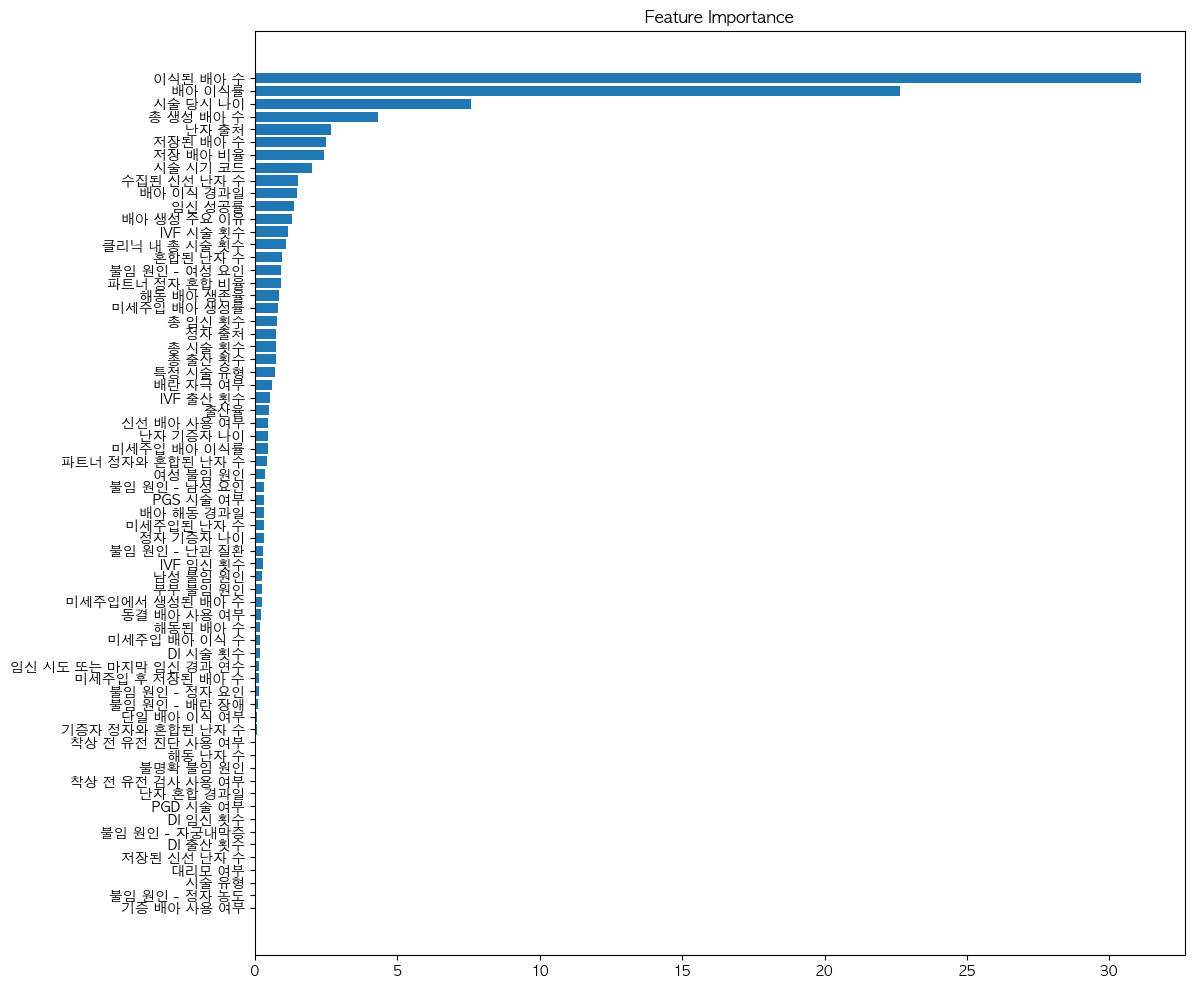

In [29]:
feature_importance = model_cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [30]:
np.array(X.columns)[sorted_idx][::-1]

array(['이식된 배아 수', '배아 이식률', '시술 당시 나이', '총 생성 배아 수', '난자 출처', '저장된 배아 수',
       '저장 배아 비율', '시술 시기 코드', '수집된 신선 난자 수', '배아 이식 경과일', '임신 성공률',
       '배아 생성 주요 이유', 'IVF 시술 횟수', '클리닉 내 총 시술 횟수', '혼합된 난자 수',
       '불임 원인 - 여성 요인', '파트너 정자 혼합 비율', '해동 배아 생존율', '미세주입 배아 생성률',
       '총 임신 횟수', '정자 출처', '총 시술 횟수', '총 출산 횟수', '특정 시술 유형', '배란 자극 여부',
       'IVF 출산 횟수', '출산율', '신선 배아 사용 여부', '난자 기증자 나이', '미세주입 배아 이식률',
       '파트너 정자와 혼합된 난자 수', '여성 불임 원인', '불임 원인 - 남성 요인', 'PGS 시술 여부',
       '배아 해동 경과일', '미세주입된 난자 수', '정자 기증자 나이', '불임 원인 - 난관 질환',
       'IVF 임신 횟수', '남성 불임 원인', '부부 불임 원인', '미세주입에서 생성된 배아 수',
       '동결 배아 사용 여부', '해동된 배아 수', '미세주입 배아 이식 수', 'DI 시술 횟수',
       '임신 시도 또는 마지막 임신 경과 연수', '미세주입 후 저장된 배아 수', '불임 원인 - 정자 요인',
       '불임 원인 - 배란 장애', '단일 배아 이식 여부', '기증자 정자와 혼합된 난자 수',
       '착상 전 유전 진단 사용 여부', '해동 난자 수', '불명확 불임 원인', '착상 전 유전 검사 사용 여부',
       '난자 혼합 경과일', 'PGD 시술 여부', 'DI 임신 횟수', '불임 원인 - 자궁내막증', 'DI 출산 횟수',
       '저장된 신선 난자 수', '대리모 여부', '시술 유형', '불임 원인 - 정

In [31]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([12919.,  2193.,  3130.,  4926.,  8665., 12401., 15736., 15480.,
        12198.,  2419.]),
 array([0.04167562, 0.11613273, 0.19058983, 0.26504694, 0.33950405,
        0.41396115, 0.48841826, 0.56287537, 0.63733248, 0.71178958,
        0.78624669]),
 <BarContainer object of 10 artists>)

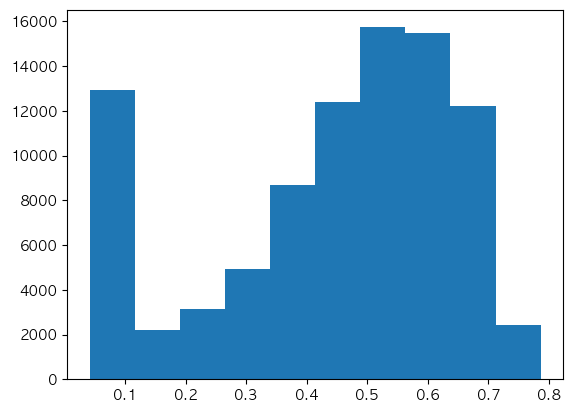

In [32]:
plt.hist(test_pred_total_mean)

In [33]:
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean

In [ ]:
sample_submission.to_csv('Add_feature_reason2_lgbmcat_cpu_mac_sunghyun+SMOTENC.csv', index=False)